In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
import functools

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
transform = transforms.Compose([
    transforms.Resize(224),  # Optional, depending on the model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=8)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def apply_mask(weights, mask):
    all_keys = weights.keys()
    target_keys = mask.keys()
    remain_keys = list(set(all_keys) - set(target_keys))
    w_sparse = {k: mask[k] * weights[k] for k in target_keys}
    w_sparse.update({k: weights[k] for k in remain_keys})
    return w_sparse

In [11]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|█████████████████████████████████████████████                                                                                                                                   | 100/391 [00:55<03:22,  1.44it/s]

0.6077341437339783


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 200/391 [01:49<02:12,  1.44it/s]

0.45581182837486267


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 300/391 [02:44<01:03,  1.43it/s]

0.2991654574871063


  2%|████                                                                                                                                                                              | 9/391 [00:05<04:29,  1.42it/s]

0.24885520339012146


 28%|█████████████████████████████████████████████████                                                                                                                               | 109/391 [01:00<03:18,  1.42it/s]

0.22441931068897247


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 209/391 [01:54<02:06,  1.44it/s]

0.25151145458221436


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 309/391 [02:49<00:57,  1.42it/s]

0.33526140451431274


  5%|████████▏                                                                                                                                                                        | 18/391 [00:10<04:20,  1.43it/s]

0.12215983867645264


 30%|█████████████████████████████████████████████████████                                                                                                                           | 118/391 [01:05<03:13,  1.41it/s]

0.34783899784088135


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 218/391 [01:59<02:01,  1.42it/s]

0.11102259904146194


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 318/391 [02:54<00:51,  1.43it/s]

0.18608319759368896


  7%|████████████▏                                                                                                                                                                    | 27/391 [00:15<04:13,  1.44it/s]

0.17122015357017517


 32%|█████████████████████████████████████████████████████████▏                                                                                                                      | 127/391 [01:10<03:03,  1.44it/s]

0.15491802990436554


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 227/391 [02:04<01:55,  1.42it/s]

0.0924108549952507


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 327/391 [02:59<00:44,  1.43it/s]

0.10673757642507553


  9%|████████████████▎                                                                                                                                                                | 36/391 [00:20<04:10,  1.42it/s]

0.07738417387008667


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 136/391 [01:15<03:02,  1.40it/s]

0.08544944226741791


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 236/391 [02:09<01:49,  1.42it/s]

0.04811616986989975


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 336/391 [03:04<00:38,  1.44it/s]

0.07420552521944046


 12%|████████████████████▎                                                                                                                                                            | 45/391 [00:25<04:02,  1.43it/s]

0.061836645007133484


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                              | 145/391 [01:34<02:52,  1.43it/s]

0.050849009305238724


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 245/391 [02:30<01:42,  1.42it/s]

0.03977680951356888


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 345/391 [03:24<00:32,  1.43it/s]

0.06839664280414581


 14%|████████████████████████▍                                                                                                                                                        | 54/391 [00:30<03:58,  1.41it/s]

0.04288797453045845


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 154/391 [01:24<02:44,  1.44it/s]

0.023235488682985306


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 254/391 [02:19<01:36,  1.42it/s]

0.015479865483939648


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 354/391 [03:14<00:26,  1.42it/s]

0.030598890036344528


 16%|████████████████████████████▌                                                                                                                                                    | 63/391 [00:35<03:50,  1.42it/s]

0.020379260182380676


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 163/391 [01:29<02:40,  1.42it/s]

0.025215892121195793


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 263/391 [02:24<01:29,  1.43it/s]

0.03394735977053642


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 363/391 [03:19<00:19,  1.42it/s]

0.03835981711745262


 18%|████████████████████████████████▌                                                                                                                                                | 72/391 [00:40<03:47,  1.40it/s]

0.014992459677159786


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 172/391 [01:35<02:34,  1.42it/s]

0.014136139303445816


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 272/391 [02:29<01:23,  1.42it/s]

0.01878424547612667


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 372/391 [03:24<00:13,  1.43it/s]

0.01624912954866886


 21%|████████████████████████████████████▋                                                                                                                                            | 81/391 [00:45<03:38,  1.42it/s]

0.012356211431324482


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 181/391 [01:39<02:29,  1.41it/s]

0.011135909706354141


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 281/391 [02:34<01:17,  1.42it/s]

0.0077649992890655994


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 381/391 [03:29<00:07,  1.42it/s]

0.01716676913201809


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:34<00:00,  1.82it/s]


In [12]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.01it/s]

Validation Loss: 0.1912, Validation Accuracy: 0.9412


In [5]:
#Gradient-based approach
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
target_sparsity = 0.95
def var_no_train(shape):
    return torch.ones(shape, dtype=torch.float32, requires_grad=False).to(DEVICE)
criterion = nn.CrossEntropyLoss()
weights = model.state_dict()
mask_init = {k: var_no_train(weights[k].shape) for k in weights}
mask_prev = {k: var_no_train(weights[k].shape) for k in weights}
w_mask = apply_mask(weights, mask_init)

absolute_weights = {name: param for name, param in model.named_parameters()}

def restore(v, x_shape, sortkeys):
    split_sizes = []
    for key in sortkeys:
        split_sizes.append(functools.reduce(lambda x, y: x*y, x_shape[key]))
    v_splits = torch.split(v, split_size_or_sections=split_sizes)
    x_restore = {}
    for i, key in enumerate(sortkeys):
        x_restore.update({key: torch.reshape(v_splits[i], x_shape[key])})
    return x_restore
mask_v = torch.cat([absolute_weights[k].view(-1) for k in absolute_weights], dim=0)
x_shape = {k: absolute_weights[k].shape for k in absolute_weights}
restore_fn = functools.partial(restore, x_shape=x_shape, sortkeys=absolute_weights)
num_params = mask_v.shape[0]
kappa = int(round(num_params * (1. - target_sparsity)))
topk, ind = torch.topk(mask_v, k=kappa, largest=True, sorted=True)
mask_sparse_v = torch.zeros_like(mask_v, dtype=torch.float32)
mask_sparse_v = mask_sparse_v.scatter_(0, ind, 1)
mask_final = restore_fn(mask_sparse_v)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps = 0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param, mask in zip(model.parameters(), mask_final):
                param.grad *= mask_final[mask]
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|█████████████████████████████████████████████                                                                                                                                   | 100/391 [00:57<03:22,  1.44it/s]

1.8666372299194336


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 200/391 [01:51<02:13,  1.43it/s]

1.4259265661239624


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 300/391 [02:46<01:03,  1.44it/s]

1.1241614818572998


  2%|████                                                                                                                                                                              | 9/391 [00:05<04:36,  1.38it/s]

0.8858033418655396


 28%|█████████████████████████████████████████████████                                                                                                                               | 109/391 [01:00<03:16,  1.43it/s]

0.761388897895813


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 209/391 [01:55<02:08,  1.42it/s]

0.711367666721344


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 309/391 [02:49<00:57,  1.42it/s]

0.5748531818389893


  5%|████████▏                                                                                                                                                                        | 18/391 [00:10<04:19,  1.44it/s]

0.6157763600349426


 30%|█████████████████████████████████████████████████████                                                                                                                           | 118/391 [01:05<03:09,  1.44it/s]

0.42026063799858093


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 218/391 [01:59<02:01,  1.42it/s]

0.6475473046302795


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 318/391 [02:54<00:51,  1.42it/s]

0.3930045962333679


  7%|████████████▏                                                                                                                                                                    | 27/391 [00:15<04:17,  1.42it/s]

0.461965411901474


 32%|█████████████████████████████████████████████████████████▏                                                                                                                      | 127/391 [01:10<03:06,  1.42it/s]

0.38325655460357666


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 227/391 [02:05<01:54,  1.44it/s]

0.34773147106170654


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 327/391 [02:59<00:45,  1.42it/s]

0.38796308636665344


  9%|████████████████▎                                                                                                                                                                | 36/391 [00:20<04:08,  1.43it/s]

0.4016753137111664


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 136/391 [01:15<02:58,  1.43it/s]

0.23947985470294952


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 236/391 [02:09<01:49,  1.42it/s]

0.4245987832546234


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 336/391 [03:04<00:38,  1.42it/s]

0.40044108033180237


 12%|████████████████████▎                                                                                                                                                            | 45/391 [00:25<04:04,  1.42it/s]

0.29315492510795593


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                              | 145/391 [01:19<02:51,  1.44it/s]

0.32479044795036316


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 245/391 [02:14<01:43,  1.41it/s]

0.33044347167015076


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 345/391 [03:09<00:32,  1.43it/s]

0.2208339273929596


 14%|████████████████████████▍                                                                                                                                                        | 54/391 [00:30<03:57,  1.42it/s]

0.2544672191143036


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 154/391 [01:24<02:47,  1.41it/s]

0.19237717986106873


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 254/391 [02:19<01:36,  1.42it/s]

0.24768541753292084


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 354/391 [03:14<00:25,  1.43it/s]

0.1808422952890396


 16%|████████████████████████████▌                                                                                                                                                    | 63/391 [00:35<03:51,  1.42it/s]

0.29471248388290405


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 163/391 [01:29<02:40,  1.42it/s]

0.17215703427791595


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 263/391 [02:24<01:29,  1.42it/s]

0.1583484709262848


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 363/391 [03:19<00:19,  1.42it/s]

0.2520039677619934


 18%|████████████████████████████████▌                                                                                                                                                | 72/391 [00:39<03:43,  1.42it/s]

0.23679976165294647


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 172/391 [01:34<02:34,  1.42it/s]

0.29834264516830444


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 272/391 [02:29<01:23,  1.43it/s]

0.12816694378852844


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 372/391 [03:23<00:13,  1.42it/s]

0.153646320104599


 21%|████████████████████████████████████▋                                                                                                                                            | 81/391 [00:44<03:38,  1.42it/s]

0.1466648429632187


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 181/391 [01:39<02:27,  1.43it/s]

0.16131047904491425


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 281/391 [02:34<01:17,  1.42it/s]

0.20776090025901794


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 381/391 [03:28<00:06,  1.43it/s]

0.2592453062534332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:33<00:00,  1.83it/s]


In [6]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.03it/s]

Validation Loss: 0.2690, Validation Accuracy: 0.9104


In [13]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
target_sparsity = 0.95
def var_no_train(shape):
    return torch.ones(shape, dtype=torch.float32, requires_grad=False).to(DEVICE)
criterion = nn.CrossEntropyLoss()
weights = model.state_dict()
mask_init = {k: var_no_train(weights[k].shape) for k in weights}
mask_prev = {k: var_no_train(weights[k].shape) for k in weights}
w_mask = apply_mask(weights, mask_init)

for inputs, labels in trainloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    absolute_gradients = {name: param.grad.abs() for name, param in model.named_parameters()}
    break

def restore(v, x_shape, sortkeys):
    split_sizes = []
    for key in sortkeys:
        split_sizes.append(functools.reduce(lambda x, y: x*y, x_shape[key]))
    v_splits = torch.split(v, split_size_or_sections=split_sizes)
    x_restore = {}
    for i, key in enumerate(sortkeys):
        x_restore.update({key: torch.reshape(v_splits[i], x_shape[key])})
    return x_restore
mask_v = torch.cat([absolute_gradients[k].view(-1) for k in absolute_gradients], dim=0)
x_shape = {k: absolute_gradients[k].shape for k in absolute_gradients}
restore_fn = functools.partial(restore, x_shape=x_shape, sortkeys=absolute_gradients)
num_params = mask_v.shape[0]
kappa = int(round(num_params * (1. - target_sparsity)))
topk, ind = torch.topk(mask_v, k=kappa, largest=True, sorted=True)
mask_sparse_v = torch.zeros_like(mask_v, dtype=torch.float32)
mask_sparse_v = mask_sparse_v.scatter_(0, ind, 1)
mask_final = restore_fn(mask_sparse_v)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps = 0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param, mask in zip(model.parameters(), mask_final):
                param.grad *= mask_final[mask]
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|█████████████████████████████████████████████                                                                                                                                   | 100/391 [00:55<03:24,  1.42it/s]

0.931821346282959


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 200/391 [01:50<02:15,  1.41it/s]

0.5741674900054932


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 300/391 [02:45<01:03,  1.42it/s]

0.385105162858963


  2%|████                                                                                                                                                                              | 9/391 [00:05<04:34,  1.39it/s]

0.34893134236335754


 28%|█████████████████████████████████████████████████                                                                                                                               | 109/391 [01:00<03:18,  1.42it/s]

0.3450608551502228


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 209/391 [01:55<02:09,  1.40it/s]

0.21582245826721191


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 309/391 [02:50<00:57,  1.42it/s]

0.3073679804801941


  5%|████████▏                                                                                                                                                                        | 18/391 [00:10<04:25,  1.40it/s]

0.3152649402618408


 30%|█████████████████████████████████████████████████████                                                                                                                           | 118/391 [01:05<03:11,  1.42it/s]

0.33420512080192566


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 218/391 [02:00<02:02,  1.42it/s]

0.1980534940958023


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 318/391 [02:55<00:51,  1.40it/s]

0.20747818052768707


  7%|████████████▏                                                                                                                                                                    | 27/391 [00:15<04:18,  1.41it/s]

0.206898495554924


 32%|█████████████████████████████████████████████████████████▏                                                                                                                      | 127/391 [01:10<03:06,  1.41it/s]

0.23441560566425323


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 227/391 [02:05<01:54,  1.44it/s]

0.19266057014465332


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 327/391 [03:00<00:45,  1.42it/s]

0.25495877861976624


  9%|████████████████▎                                                                                                                                                                | 36/391 [00:20<04:11,  1.41it/s]

0.19499941170215607


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 136/391 [01:15<02:58,  1.42it/s]

0.23278912901878357


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 236/391 [02:10<01:49,  1.42it/s]

0.18943290412425995


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 336/391 [03:05<00:38,  1.43it/s]

0.1265431046485901


 12%|████████████████████▎                                                                                                                                                            | 45/391 [00:25<04:05,  1.41it/s]

0.18841958045959473


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                              | 145/391 [01:20<02:53,  1.42it/s]

0.11690015345811844


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 245/391 [02:15<01:43,  1.42it/s]

0.13169623911380768


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 345/391 [03:10<00:32,  1.41it/s]

0.15249930322170258


 14%|████████████████████████▍                                                                                                                                                        | 54/391 [00:30<03:58,  1.42it/s]

0.2374977171421051


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 154/391 [01:39<02:47,  1.41it/s]

0.1946416199207306


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 254/391 [02:34<01:36,  1.43it/s]

0.08580175787210464


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 354/391 [03:29<00:25,  1.43it/s]

0.12887385487556458


 16%|████████████████████████████▌                                                                                                                                                    | 63/391 [00:35<03:50,  1.42it/s]

0.1168210580945015


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 163/391 [01:30<02:40,  1.42it/s]

0.1563228815793991


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 263/391 [02:25<01:30,  1.41it/s]

0.19128753244876862


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 363/391 [03:20<00:19,  1.42it/s]

0.11429706960916519


 18%|████████████████████████████████▌                                                                                                                                                | 72/391 [00:40<03:43,  1.43it/s]

0.07741370052099228


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 172/391 [01:34<02:33,  1.43it/s]

0.09181968867778778


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 272/391 [02:29<01:24,  1.41it/s]

0.13726644217967987


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 372/391 [03:24<00:13,  1.42it/s]

0.12001020461320877


 21%|████████████████████████████████████▋                                                                                                                                            | 81/391 [00:45<03:36,  1.43it/s]

0.13669848442077637


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 181/391 [01:39<02:25,  1.44it/s]

0.0985301062464714


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 281/391 [02:34<01:17,  1.42it/s]

0.14234574139118195


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 381/391 [03:29<00:07,  1.42it/s]

0.16041718423366547


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:34<00:00,  1.82it/s]


In [14]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.03it/s]

Validation Loss: 0.2098, Validation Accuracy: 0.9305


Text(0, 0.5, 'Percent of pruned parameters')

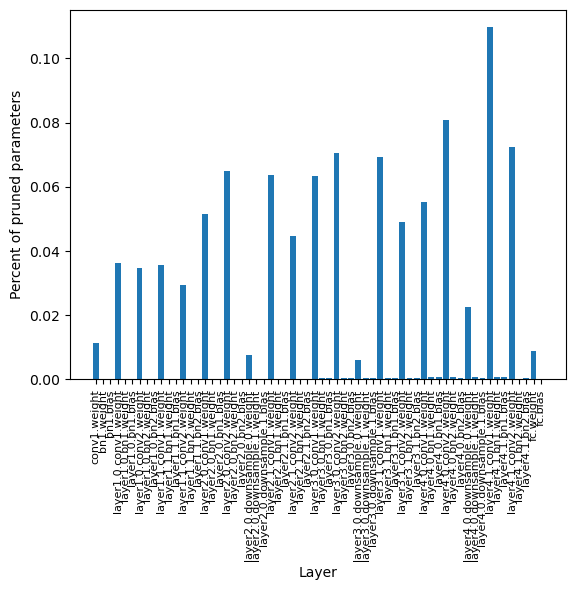

In [15]:
import matplotlib.pyplot as plt
mask_percent_dict = {}
for item in mask_final:
    mask_percent_dict[item] = torch.sum(mask_final[item]) / (num_params * (1-target_sparsity))
cur_sum = 0
xs = []
ys = []
for item in mask_percent_dict:
    num = mask_percent_dict[item].item()
    xs.append(item)
    ys.append(num)
plt.bar(xs, ys)
plt.xlabel("Layer")
plt.xticks(rotation='vertical', fontsize=8)
plt.ylabel("Percent of pruned parameters")

Text(0, 0.5, 'Percent of pruned parameters')

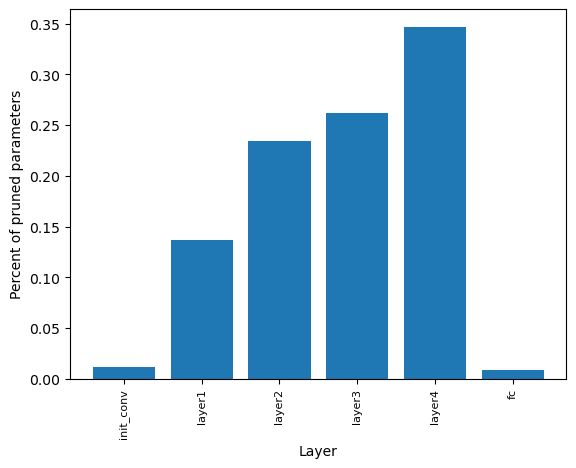

In [16]:
import matplotlib.pyplot as plt
mask_percent_dict = {}
for item in mask_final:
    mask_percent_dict[item] = torch.sum(mask_final[item]) / (num_params * (1-target_sparsity))
xs = ['init_conv', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
ys = {}
for item in xs:
    ys[item] = 0
count = 0
for item in mask_percent_dict:
    num = mask_percent_dict[item].item()
    if count < 3:
        ys['init_conv'] += num
    elif 'layer1' in item:
        ys['layer1'] += num
    elif 'layer2' in item:
        ys['layer2'] += num
    elif 'layer3' in item:
        ys['layer3'] += num
    elif 'layer4' in item:
        ys['layer4'] += num
    else:
        ys['fc'] += num
    count += 1
plt.bar(xs, list(ys.values()))
plt.xlabel("Layer")
plt.xticks(rotation='vertical', fontsize=8)
plt.ylabel("Percent of pruned parameters")

In [17]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
target_sparsity = 0.95
def var_no_train(shape):
    return torch.ones(shape, dtype=torch.float32, requires_grad=False).to(DEVICE)
criterion = nn.CrossEntropyLoss()
weights = model.state_dict()
mask_init = {k: var_no_train(weights[k].shape) for k in weights}
mask_prev = {k: var_no_train(weights[k].shape) for k in weights}
w_mask = apply_mask(weights, mask_init)

for inputs, labels in trainloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    absolute_gradients = {name: param.grad.abs() for name, param in model.named_parameters()}
    break

def restore(v, x_shape, sortkeys):
    split_sizes = []
    for key in sortkeys:
        split_sizes.append(functools.reduce(lambda x, y: x*y, x_shape[key]))
    v_splits = torch.split(v, split_size_or_sections=split_sizes)
    x_restore = {}
    for i, key in enumerate(sortkeys):
        x_restore.update({key: torch.reshape(v_splits[i], x_shape[key])})
    return x_restore
mask_v = torch.cat([absolute_gradients[k].view(-1) for k in absolute_gradients], dim=0)
x_shape = {k: absolute_gradients[k].shape for k in absolute_gradients}
restore_fn = functools.partial(restore, x_shape=x_shape, sortkeys=absolute_gradients)
num_params = mask_v.shape[0]
kappa = int(round(num_params * (1. - target_sparsity)))
ind = torch.randperm(num_params)[:kappa].to(DEVICE)
mask_sparse_v = torch.zeros_like(mask_v, dtype=torch.float32)
mask_sparse_v = mask_sparse_v.scatter_(0, ind, 1)
mask_final = restore_fn(mask_sparse_v)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps = 0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param, mask in zip(model.parameters(), mask_final):
                param.grad *= mask_final[mask]
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|█████████████████████████████████████████████                                                                                                                                   | 100/391 [00:55<03:24,  1.42it/s]

2.1929190158843994


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 200/391 [01:50<02:13,  1.43it/s]

1.8853602409362793


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 300/391 [02:44<01:04,  1.41it/s]

1.7354650497436523


  2%|████                                                                                                                                                                              | 9/391 [00:05<04:34,  1.39it/s]

1.560059666633606


 28%|█████████████████████████████████████████████████                                                                                                                               | 109/391 [01:00<03:17,  1.43it/s]

1.4880335330963135


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 209/391 [01:55<02:07,  1.42it/s]

1.2593411207199097


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 309/391 [02:49<00:57,  1.42it/s]

1.2767415046691895


  5%|████████▏                                                                                                                                                                        | 18/391 [00:10<04:23,  1.42it/s]

1.1398550271987915


 30%|█████████████████████████████████████████████████████                                                                                                                           | 118/391 [01:05<03:13,  1.41it/s]

1.0687839984893799


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 218/391 [01:59<02:01,  1.42it/s]

0.9754984378814697


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 318/391 [02:54<00:51,  1.43it/s]

0.9002243280410767


  7%|████████████▏                                                                                                                                                                    | 27/391 [00:15<04:16,  1.42it/s]

0.6810091733932495


 32%|█████████████████████████████████████████████████████████▏                                                                                                                      | 127/391 [01:10<03:04,  1.43it/s]

0.8749212026596069


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 227/391 [02:04<01:56,  1.41it/s]

0.6579216718673706


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 327/391 [02:59<00:44,  1.42it/s]

0.6998765468597412


  9%|████████████████▎                                                                                                                                                                | 36/391 [00:20<04:11,  1.41it/s]

0.6339506506919861


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 136/391 [01:15<03:00,  1.41it/s]

0.7994133234024048


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 236/391 [02:09<01:48,  1.43it/s]

0.7137415409088135


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 336/391 [03:04<00:38,  1.43it/s]

0.6913105249404907


 12%|████████████████████▎                                                                                                                                                            | 45/391 [00:25<04:02,  1.43it/s]

0.6057009100914001


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                              | 145/391 [01:19<02:52,  1.42it/s]

0.7107596397399902


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 245/391 [02:14<01:43,  1.41it/s]

0.6389697790145874


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 345/391 [03:09<00:32,  1.43it/s]

0.6708920001983643


 14%|████████████████████████▍                                                                                                                                                        | 54/391 [00:30<03:57,  1.42it/s]

0.5571394562721252


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 154/391 [01:36<05:44,  1.45s/it]

0.43671515583992004


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 254/391 [02:31<01:36,  1.41it/s]

0.4438067674636841


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 354/391 [03:26<00:26,  1.41it/s]

0.61527019739151


 16%|████████████████████████████▌                                                                                                                                                    | 63/391 [00:35<03:50,  1.42it/s]

0.3494184613227844


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 163/391 [01:30<02:39,  1.43it/s]

0.3264605402946472


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 263/391 [02:24<01:30,  1.42it/s]

0.3800315260887146


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 363/391 [03:19<00:19,  1.40it/s]

0.4529408812522888


 18%|████████████████████████████████▌                                                                                                                                                | 72/391 [00:40<03:44,  1.42it/s]

0.5316038727760315


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 172/391 [01:34<02:34,  1.42it/s]

0.35286927223205566


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 272/391 [02:29<01:24,  1.41it/s]

0.45243552327156067


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 372/391 [03:24<00:13,  1.41it/s]

0.37135326862335205


 21%|████████████████████████████████████▋                                                                                                                                            | 81/391 [00:45<03:38,  1.42it/s]

0.34469980001449585


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 181/391 [01:39<02:27,  1.42it/s]

0.3696761429309845


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 281/391 [02:34<01:17,  1.43it/s]

0.35047245025634766


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 381/391 [03:29<00:07,  1.42it/s]

0.41336876153945923


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:34<00:00,  1.82it/s]


In [18]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.10it/s]

Validation Loss: 0.4181, Validation Accuracy: 0.8595


In [4]:
### CIFAR100 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
transform = transforms.Compose([
    transforms.Resize(224),  # Optional, depending on the model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainset = datasets.CIFAR100(root='./data2', train=True, download=False, transform=transform)
testset = datasets.CIFAR100(root='./data2', train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#Gradient-based approach
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
target_sparsity = 0.95
def var_no_train(shape):
    return torch.ones(shape, dtype=torch.float32, requires_grad=False).to(DEVICE)
criterion = nn.CrossEntropyLoss()
weights = model.state_dict()
mask_init = {k: var_no_train(weights[k].shape) for k in weights}
mask_prev = {k: var_no_train(weights[k].shape) for k in weights}
w_mask = apply_mask(weights, mask_init)

absolute_weights = {name: param for name, param in model.named_parameters()}

def restore(v, x_shape, sortkeys):
    split_sizes = []
    for key in sortkeys:
        split_sizes.append(functools.reduce(lambda x, y: x*y, x_shape[key]))
    v_splits = torch.split(v, split_size_or_sections=split_sizes)
    x_restore = {}
    for i, key in enumerate(sortkeys):
        x_restore.update({key: torch.reshape(v_splits[i], x_shape[key])})
    return x_restore
    
mask_v = torch.cat([absolute_weights[k].view(-1) for k in absolute_weights], dim=0)
x_shape = {k: absolute_weights[k].shape for k in absolute_weights}
restore_fn = functools.partial(restore, x_shape=x_shape, sortkeys=absolute_weights)
num_params = mask_v.shape[0]
kappa = int(round(num_params * (1. - target_sparsity)))
topk, ind = torch.topk(mask_v, k=kappa, largest=True, sorted=True)
mask_sparse_v = torch.zeros_like(mask_v, dtype=torch.float32)
mask_sparse_v = mask_sparse_v.scatter_(0, ind, 1)
mask_final = restore_fn(mask_sparse_v)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps = 0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param, mask in zip(model.parameters(), mask_final):
                param.grad *= mask_final[mask]
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|█████████████████████████████████████████████                                                                                                                                   | 100/391 [00:57<03:22,  1.43it/s]

4.629190444946289


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 200/391 [01:51<02:15,  1.41it/s]

4.43913459777832


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 300/391 [02:45<01:04,  1.42it/s]

4.338040828704834


  2%|████                                                                                                                                                                              | 9/391 [00:05<04:27,  1.43it/s]

4.240654468536377


 28%|█████████████████████████████████████████████████                                                                                                                               | 109/391 [00:59<03:18,  1.42it/s]

4.145578384399414


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 209/391 [01:54<02:06,  1.44it/s]

3.996535301208496


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 309/391 [02:48<00:57,  1.42it/s]

3.8591578006744385


  5%|████████▏                                                                                                                                                                        | 18/391 [00:10<04:20,  1.43it/s]

3.743067979812622


 30%|█████████████████████████████████████████████████████                                                                                                                           | 118/391 [01:05<03:13,  1.41it/s]

3.4538745880126953


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 218/391 [01:59<02:00,  1.44it/s]

3.4419515132904053


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 318/391 [02:53<00:50,  1.44it/s]

3.2604408264160156


  7%|████████████▏                                                                                                                                                                    | 27/391 [00:15<04:15,  1.42it/s]

3.051349639892578


 32%|█████████████████████████████████████████████████████████▏                                                                                                                      | 127/391 [01:09<03:06,  1.42it/s]

3.1377670764923096


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 227/391 [02:04<01:56,  1.41it/s]

3.068418264389038


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 327/391 [02:58<00:44,  1.44it/s]

2.8127081394195557


  9%|████████████████▎                                                                                                                                                                | 36/391 [00:20<04:12,  1.41it/s]

2.643726110458374


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 136/391 [01:14<02:58,  1.43it/s]

2.561948299407959


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 236/391 [02:09<01:50,  1.41it/s]

2.6945066452026367


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 336/391 [03:04<00:38,  1.43it/s]

2.3634567260742188


 12%|████████████████████▎                                                                                                                                                            | 45/391 [00:25<04:01,  1.43it/s]

2.1521763801574707


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                              | 145/391 [01:19<02:53,  1.42it/s]

2.372779607772827


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 245/391 [02:14<01:41,  1.44it/s]

2.134526252746582


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 345/391 [03:08<00:32,  1.42it/s]

2.421480417251587


 14%|████████████████████████▍                                                                                                                                                        | 54/391 [00:29<03:57,  1.42it/s]

2.101943016052246


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 154/391 [01:24<02:47,  1.42it/s]

1.9819434881210327


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 254/391 [02:19<01:36,  1.41it/s]

2.0714573860168457


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 354/391 [03:14<00:26,  1.42it/s]

1.8935503959655762


 16%|████████████████████████████▌                                                                                                                                                    | 63/391 [00:34<03:53,  1.41it/s]

1.9603196382522583


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 163/391 [01:29<02:39,  1.43it/s]

1.8986345529556274


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 263/391 [02:24<01:29,  1.42it/s]

1.7975642681121826


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 363/391 [03:18<00:19,  1.42it/s]

1.84160315990448


 18%|████████████████████████████████▌                                                                                                                                                | 72/391 [00:39<03:41,  1.44it/s]

1.7096973657608032


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 172/391 [01:34<02:31,  1.44it/s]

1.6476813554763794


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 272/391 [02:29<01:23,  1.42it/s]

1.8815582990646362


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 372/391 [03:23<00:13,  1.43it/s]

1.4024379253387451


 21%|████████████████████████████████████▋                                                                                                                                            | 81/391 [00:44<03:37,  1.42it/s]

1.7368732690811157


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 181/391 [01:39<02:27,  1.42it/s]

1.6647922992706299


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 281/391 [02:33<01:17,  1.42it/s]

1.5893882513046265


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 381/391 [03:28<00:07,  1.43it/s]

1.2859922647476196


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:33<00:00,  1.83it/s]


In [6]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.13it/s]

Validation Loss: 1.5998, Validation Accuracy: 0.5785


In [20]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|█████████████████████████████████████████████                                                                                                                                   | 100/391 [00:55<03:22,  1.44it/s]

3.970900058746338


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 200/391 [01:49<02:14,  1.42it/s]

3.0398411750793457


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 300/391 [02:44<01:03,  1.43it/s]

2.2865262031555176


  2%|████                                                                                                                                                                              | 9/391 [00:05<04:30,  1.41it/s]

1.867056965827942


 28%|█████████████████████████████████████████████████                                                                                                                               | 109/391 [01:00<03:16,  1.43it/s]

1.5653969049453735


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 209/391 [01:54<02:08,  1.42it/s]

1.417650580406189


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 309/391 [02:49<00:57,  1.42it/s]

1.297028660774231


  5%|████████▏                                                                                                                                                                        | 18/391 [00:10<04:22,  1.42it/s]

1.233356237411499


 30%|█████████████████████████████████████████████████████                                                                                                                           | 118/391 [01:04<03:12,  1.42it/s]

1.1062132120132446


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 218/391 [01:59<02:01,  1.42it/s]

1.0100090503692627


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 318/391 [02:54<00:50,  1.44it/s]

1.1349574327468872


  7%|████████████▏                                                                                                                                                                    | 27/391 [00:15<04:18,  1.41it/s]

1.0922874212265015


 32%|█████████████████████████████████████████████████████████▏                                                                                                                      | 127/391 [01:09<03:06,  1.42it/s]

1.0309168100357056


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 227/391 [02:04<01:56,  1.41it/s]

0.8706945776939392


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 327/391 [02:59<00:45,  1.41it/s]

0.8934231400489807


  9%|████████████████▎                                                                                                                                                                | 36/391 [00:20<04:11,  1.41it/s]

0.9771314859390259


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 136/391 [01:14<02:59,  1.42it/s]

0.7135530710220337


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 236/391 [02:09<01:49,  1.42it/s]

0.7648957967758179


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 336/391 [03:03<00:38,  1.43it/s]

0.6218147873878479


 12%|████████████████████▎                                                                                                                                                            | 45/391 [00:25<04:04,  1.41it/s]

0.6780031323432922


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                              | 145/391 [01:19<02:52,  1.42it/s]

0.5177943110466003


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 245/391 [02:24<01:41,  1.43it/s]

0.6452722549438477


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 345/391 [03:19<00:32,  1.42it/s]

0.7016600370407104


 14%|████████████████████████▍                                                                                                                                                        | 54/391 [00:30<03:57,  1.42it/s]

0.581211268901825


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 154/391 [01:24<02:47,  1.41it/s]

0.522400975227356


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 254/391 [02:19<01:36,  1.41it/s]

0.5979393720626831


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 354/391 [03:13<00:26,  1.42it/s]

0.5678535103797913


 16%|████████████████████████████▌                                                                                                                                                    | 63/391 [00:35<03:53,  1.40it/s]

0.490106463432312


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 163/391 [01:29<02:40,  1.42it/s]

0.4488147497177124


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 263/391 [02:24<01:29,  1.42it/s]

0.3970226049423218


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 363/391 [03:19<00:19,  1.44it/s]

0.46147581934928894


 18%|████████████████████████████████▌                                                                                                                                                | 72/391 [00:39<03:43,  1.43it/s]

0.44083312153816223


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 172/391 [01:34<02:34,  1.42it/s]

0.4931449592113495


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 272/391 [02:29<01:23,  1.42it/s]

0.4330182373523712


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 372/391 [03:23<00:13,  1.43it/s]

0.4724588990211487


 21%|████████████████████████████████████▋                                                                                                                                            | 81/391 [00:44<03:35,  1.44it/s]

0.3229662775993347


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 181/391 [01:39<02:28,  1.42it/s]

0.4076535403728485


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 281/391 [02:33<01:17,  1.43it/s]

0.2660222053527832


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 381/391 [03:28<00:06,  1.43it/s]

0.2562287747859955


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:33<00:00,  1.83it/s]


In [21]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.14it/s]

Validation Loss: 0.7444, Validation Accuracy: 0.7798


In [22]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
target_sparsity = 0.95
def var_no_train(shape):
    return torch.ones(shape, dtype=torch.float32, requires_grad=False).to(DEVICE)
criterion = nn.CrossEntropyLoss()
weights = model.state_dict()
mask_init = {k: var_no_train(weights[k].shape) for k in weights}
mask_prev = {k: var_no_train(weights[k].shape) for k in weights}
w_mask = apply_mask(weights, mask_init)

for inputs, labels in trainloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    absolute_gradients = {name: param.grad.abs() for name, param in model.named_parameters()}
    break

def restore(v, x_shape, sortkeys):
    split_sizes = []
    for key in sortkeys:
        split_sizes.append(functools.reduce(lambda x, y: x*y, x_shape[key]))
    v_splits = torch.split(v, split_size_or_sections=split_sizes)
    x_restore = {}
    for i, key in enumerate(sortkeys):
        x_restore.update({key: torch.reshape(v_splits[i], x_shape[key])})
    return x_restore
mask_v = torch.cat([absolute_gradients[k].view(-1) for k in absolute_gradients], dim=0)
x_shape = {k: absolute_gradients[k].shape for k in absolute_gradients}
restore_fn = functools.partial(restore, x_shape=x_shape, sortkeys=absolute_gradients)
num_params = mask_v.shape[0]
kappa = int(round(num_params * (1. - target_sparsity)))
topk, ind = torch.topk(mask_v, k=kappa, largest=True, sorted=True)
mask_sparse_v = torch.zeros_like(mask_v, dtype=torch.float32)
mask_sparse_v = mask_sparse_v.scatter_(0, ind, 1)
mask_final = restore_fn(mask_sparse_v)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps = 0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param, mask in zip(model.parameters(), mask_final):
                param.grad *= mask_final[mask]
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|█████████████████████████████████████████████                                                                                                                                   | 100/391 [00:54<03:26,  1.41it/s]

4.241849899291992


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 200/391 [01:49<02:14,  1.42it/s]

3.818373918533325


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 300/391 [02:44<01:03,  1.42it/s]

3.403097629547119


  2%|████                                                                                                                                                                              | 9/391 [00:05<04:29,  1.42it/s]

2.853091239929199


 28%|█████████████████████████████████████████████████                                                                                                                               | 109/391 [00:59<03:17,  1.42it/s]

2.5607430934906006


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 209/391 [01:54<02:08,  1.41it/s]

2.1123721599578857


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 309/391 [02:49<00:58,  1.41it/s]

2.0922021865844727


  5%|████████▏                                                                                                                                                                        | 18/391 [00:10<04:24,  1.41it/s]

1.838777780532837


 30%|█████████████████████████████████████████████████████                                                                                                                           | 118/391 [01:05<03:12,  1.42it/s]

1.7335807085037231


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 218/391 [01:59<02:01,  1.42it/s]

1.7108479738235474


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 318/391 [02:54<00:50,  1.44it/s]

1.713902473449707


  7%|████████████▏                                                                                                                                                                    | 27/391 [00:15<04:14,  1.43it/s]

1.4292856454849243


 32%|█████████████████████████████████████████████████████████▏                                                                                                                      | 127/391 [01:09<03:06,  1.41it/s]

1.4819611310958862


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 227/391 [02:04<01:55,  1.42it/s]

1.3358018398284912


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 327/391 [02:59<00:44,  1.43it/s]

1.383862018585205


  9%|████████████████▎                                                                                                                                                                | 36/391 [00:20<04:10,  1.42it/s]

1.2594997882843018


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 136/391 [01:14<03:02,  1.40it/s]

1.2200438976287842


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 236/391 [02:09<01:49,  1.42it/s]

1.172782063484192


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 336/391 [03:04<00:38,  1.41it/s]

1.0965616703033447


 12%|████████████████████▎                                                                                                                                                            | 45/391 [00:25<04:05,  1.41it/s]

1.1336910724639893


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                              | 145/391 [01:19<02:54,  1.41it/s]

1.0396674871444702


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 245/391 [02:14<01:43,  1.41it/s]

1.057991623878479


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 345/391 [03:09<00:32,  1.43it/s]

0.9326720237731934


 14%|████████████████████████▍                                                                                                                                                        | 54/391 [00:36<06:58,  1.24s/it]

1.1526347398757935


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 154/391 [01:35<02:47,  1.42it/s]

0.9951571822166443


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 254/391 [02:30<01:36,  1.42it/s]

1.0051791667938232


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 354/391 [03:24<00:25,  1.43it/s]

0.934058666229248


 16%|████████████████████████████▌                                                                                                                                                    | 63/391 [00:34<03:49,  1.43it/s]

0.9693663120269775


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 163/391 [01:29<02:39,  1.43it/s]

0.9107125997543335


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 263/391 [02:24<01:30,  1.41it/s]

0.8074429631233215


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 363/391 [03:18<00:19,  1.43it/s]

0.9021731615066528


 18%|████████████████████████████████▌                                                                                                                                                | 72/391 [00:39<03:43,  1.42it/s]

0.7153631448745728


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 172/391 [01:34<02:32,  1.44it/s]

0.7508760094642639


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 272/391 [02:28<01:23,  1.42it/s]

0.8591876029968262


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 372/391 [03:23<00:13,  1.43it/s]

0.9493691921234131


 21%|████████████████████████████████████▋                                                                                                                                            | 81/391 [00:44<03:37,  1.43it/s]

0.8352697491645813


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 181/391 [01:39<02:27,  1.42it/s]

0.9583665132522583


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 281/391 [02:33<01:17,  1.41it/s]

0.7644636034965515


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 381/391 [03:28<00:06,  1.43it/s]

0.7349766492843628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:33<00:00,  1.83it/s]


In [23]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.19it/s]

Validation Loss: 0.9303, Validation Accuracy: 0.7392


Text(0, 0.5, 'Percent of pruned parameters')

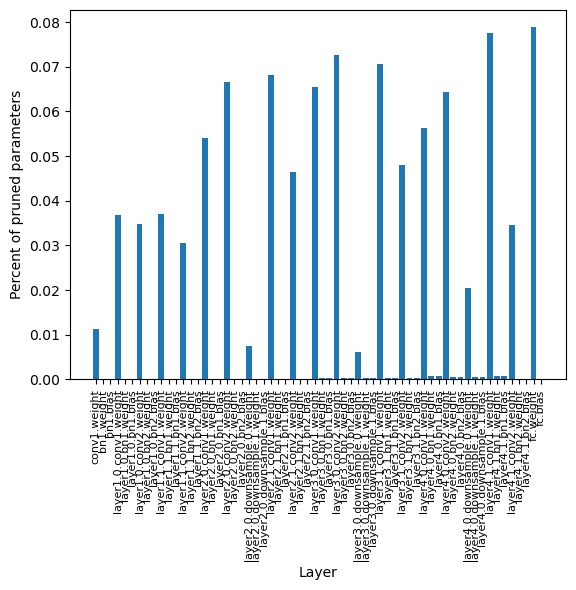

In [24]:
import matplotlib.pyplot as plt
mask_percent_dict = {}
for item in mask_final:
    mask_percent_dict[item] = torch.sum(mask_final[item]) / (num_params * (1-target_sparsity))
cur_sum = 0
xs = []
ys = []
for item in mask_percent_dict:
    num = mask_percent_dict[item].item()
    xs.append(item)
    ys.append(num)
plt.bar(xs, ys)
plt.xlabel("Layer")
plt.xticks(rotation='vertical', fontsize=8)
plt.ylabel("Percent of pruned parameters")

Text(0, 0.5, 'Percent of pruned parameters')

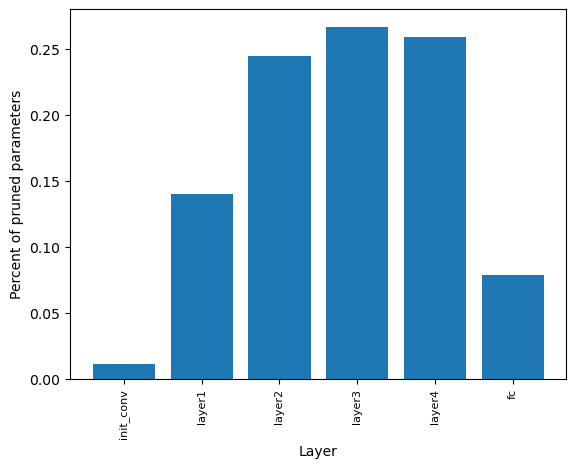

In [25]:
import matplotlib.pyplot as plt
mask_percent_dict = {}
for item in mask_final:
    mask_percent_dict[item] = torch.sum(mask_final[item]) / (num_params * (1-target_sparsity))
xs = ['init_conv', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
ys = {}
for item in xs:
    ys[item] = 0
count = 0
for item in mask_percent_dict:
    num = mask_percent_dict[item].item()
    if count < 3:
        ys['init_conv'] += num
    elif 'layer1' in item:
        ys['layer1'] += num
    elif 'layer2' in item:
        ys['layer2'] += num
    elif 'layer3' in item:
        ys['layer3'] += num
    elif 'layer4' in item:
        ys['layer4'] += num
    else:
        ys['fc'] += num
    count += 1
plt.bar(xs, list(ys.values()))
plt.xlabel("Layer")
plt.xticks(rotation='vertical', fontsize=8)
plt.ylabel("Percent of pruned parameters")

In [7]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
target_sparsity = 0.95
def var_no_train(shape):
    return torch.ones(shape, dtype=torch.float32, requires_grad=False).to(DEVICE)
criterion = nn.CrossEntropyLoss()
weights = model.state_dict()
mask_init = {k: var_no_train(weights[k].shape) for k in weights}
mask_prev = {k: var_no_train(weights[k].shape) for k in weights}
w_mask = apply_mask(weights, mask_init)

for inputs, labels in trainloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    absolute_gradients = {name: param.grad.abs() for name, param in model.named_parameters()}
    break

def restore(v, x_shape, sortkeys):
    split_sizes = []
    for key in sortkeys:
        split_sizes.append(functools.reduce(lambda x, y: x*y, x_shape[key]))
    v_splits = torch.split(v, split_size_or_sections=split_sizes)
    x_restore = {}
    for i, key in enumerate(sortkeys):
        x_restore.update({key: torch.reshape(v_splits[i], x_shape[key])})
    return x_restore
mask_v = torch.cat([absolute_gradients[k].view(-1) for k in absolute_gradients], dim=0)
x_shape = {k: absolute_gradients[k].shape for k in absolute_gradients}
restore_fn = functools.partial(restore, x_shape=x_shape, sortkeys=absolute_gradients)
num_params = mask_v.shape[0]
kappa = int(round(num_params * (1. - target_sparsity)))
ind = torch.randperm(num_params)[:kappa].to(DEVICE)
mask_sparse_v = torch.zeros_like(mask_v, dtype=torch.float32)
mask_sparse_v = mask_sparse_v.scatter_(0, ind, 1)
mask_final = restore_fn(mask_sparse_v)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps = 0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param, mask in zip(model.parameters(), mask_final):
                param.grad *= mask_final[mask]
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|█████████████████████████████████████████████                                                                                                                                   | 100/391 [00:54<03:23,  1.43it/s]

4.698086261749268


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 200/391 [01:48<02:14,  1.42it/s]

4.574109077453613


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 300/391 [02:44<01:04,  1.41it/s]

4.578881740570068


  2%|████                                                                                                                                                                              | 9/391 [00:05<04:31,  1.41it/s]

4.563608169555664


 28%|█████████████████████████████████████████████████                                                                                                                               | 109/391 [01:00<03:18,  1.42it/s]

4.521270751953125


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 209/391 [01:55<02:07,  1.43it/s]

4.436837196350098


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 309/391 [02:49<00:58,  1.41it/s]

4.3947014808654785


  5%|████████▏                                                                                                                                                                        | 18/391 [00:10<04:21,  1.42it/s]

4.395298004150391


 30%|█████████████████████████████████████████████████████                                                                                                                           | 118/391 [01:04<03:12,  1.42it/s]

4.278769016265869


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 218/391 [01:59<02:01,  1.42it/s]

4.221703052520752


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 318/391 [02:54<00:51,  1.42it/s]

4.226647853851318


  7%|████████████▏                                                                                                                                                                    | 27/391 [00:15<04:12,  1.44it/s]

4.0449371337890625


 32%|█████████████████████████████████████████████████████████▏                                                                                                                      | 127/391 [01:09<03:06,  1.42it/s]

4.156567573547363


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 227/391 [02:04<01:55,  1.42it/s]

4.080354690551758


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 327/391 [02:59<00:45,  1.42it/s]

4.026943206787109


  9%|████████████████▎                                                                                                                                                                | 36/391 [00:20<04:09,  1.42it/s]

3.887105941772461


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 136/391 [01:14<02:59,  1.42it/s]

4.018571376800537


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 236/391 [02:09<01:48,  1.43it/s]

3.9896581172943115


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 336/391 [03:04<00:38,  1.42it/s]

3.741049289703369


 12%|████████████████████▎                                                                                                                                                            | 45/391 [00:24<04:06,  1.40it/s]

3.906893253326416


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                              | 145/391 [01:19<02:52,  1.43it/s]

3.626404047012329


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 245/391 [02:14<01:42,  1.42it/s]

3.607959508895874


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 345/391 [03:08<00:32,  1.41it/s]

3.686366319656372


 14%|████████████████████████▍                                                                                                                                                        | 54/391 [00:29<03:56,  1.42it/s]

3.679738759994507


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 154/391 [01:24<02:44,  1.44it/s]

3.4511525630950928


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 254/391 [02:19<01:36,  1.43it/s]

3.481515407562256


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 354/391 [03:14<00:26,  1.42it/s]

3.402716636657715


 16%|████████████████████████████▌                                                                                                                                                    | 63/391 [00:34<03:49,  1.43it/s]

3.353538751602173


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 163/391 [01:29<02:40,  1.42it/s]

3.3964195251464844


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 263/391 [02:24<01:29,  1.43it/s]

3.3109521865844727


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 363/391 [03:19<00:19,  1.43it/s]

3.217946767807007


 18%|████████████████████████████████▌                                                                                                                                                | 72/391 [00:39<03:42,  1.43it/s]

3.144960880279541


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 172/391 [01:34<02:34,  1.41it/s]

3.037601947784424


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 272/391 [02:29<01:23,  1.43it/s]

2.988391160964966


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 372/391 [03:23<00:13,  1.43it/s]

3.1262974739074707


 21%|████████████████████████████████████▋                                                                                                                                            | 81/391 [00:44<03:39,  1.41it/s]

3.314329147338867


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 181/391 [01:39<02:28,  1.42it/s]

3.1116750240325928


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 281/391 [02:34<01:18,  1.40it/s]

3.011880874633789


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 381/391 [03:29<00:07,  1.42it/s]

3.0877039432525635


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:34<00:00,  1.83it/s]


In [8]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.15it/s]

Validation Loss: 2.9730, Validation Accuracy: 0.3243


In [7]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
transform = transforms.Compose([
    transforms.Resize(224),  # Optional, depending on the model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainset = datasets.CelebA(root='/home/mkolod/CS330Project/data3', split='train', download=False, transform=transform)
testset = datasets.CelebA(root='/home/mkolod/CS330Project/data3', split='test', download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 40
criterion = nn.BCEWithLogitsLoss()
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=5
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

  8%|█████████████▊                                                                                                                                                                 | 100/1272 [01:14<18:21,  1.06it/s]

0.4412863254547119


 16%|███████████████████████████▌                                                                                                                                                   | 200/1272 [02:26<16:42,  1.07it/s]

0.4030486047267914


 24%|█████████████████████████████████████████▎                                                                                                                                     | 300/1272 [03:39<15:23,  1.05it/s]

0.3829447627067566


 31%|███████████████████████████████████████████████████████                                                                                                                        | 400/1272 [04:52<13:42,  1.06it/s]

0.3790972828865051


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                          | 500/1272 [06:05<12:06,  1.06it/s]

0.38302794098854065


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 600/1272 [07:18<10:38,  1.05it/s]

0.3499334752559662


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 700/1272 [08:31<08:56,  1.07it/s]

0.36290326714515686


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 800/1272 [09:44<07:25,  1.06it/s]

0.33853980898857117


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 900/1272 [10:56<05:45,  1.08it/s]

0.3415662944316864


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1000/1272 [12:09<04:14,  1.07it/s]

0.3306259512901306


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1100/1272 [13:22<02:41,  1.06it/s]

0.3484080135822296


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1200/1272 [14:35<01:08,  1.06it/s]

0.33111271262168884


  2%|███▊                                                                                                                                                                            | 28/1272 [00:21<19:29,  1.06it/s]

0.3235307037830353


 10%|█████████████████▌                                                                                                                                                             | 128/1272 [01:34<18:01,  1.06it/s]

0.30646181106567383


 18%|███████████████████████████████▎                                                                                                                                               | 228/1272 [02:46<16:09,  1.08it/s]

0.30436864495277405


 26%|█████████████████████████████████████████████▏                                                                                                                                 | 328/1272 [03:59<14:46,  1.06it/s]

0.3076566457748413


 34%|██████████████████████████████████████████████████████████▉                                                                                                                    | 428/1272 [05:12<13:09,  1.07it/s]

0.31244608759880066


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                      | 528/1272 [06:25<11:40,  1.06it/s]

0.29398536682128906


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 628/1272 [07:38<10:08,  1.06it/s]

0.3098066747188568


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 728/1272 [08:51<08:32,  1.06it/s]

0.29207465052604675


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 828/1272 [10:04<06:55,  1.07it/s]

0.2923245429992676


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 928/1272 [11:16<05:23,  1.06it/s]

0.3009531795978546


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1028/1272 [12:29<03:49,  1.06it/s]

0.29527467489242554


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1128/1272 [13:42<02:14,  1.07it/s]

0.2842887043952942


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1228/1272 [14:55<00:41,  1.06it/s]

0.2846013009548187


  4%|███████▋                                                                                                                                                                        | 56/1272 [00:41<18:56,  1.07it/s]

0.28901952505111694


 12%|█████████████████████▍                                                                                                                                                         | 156/1272 [01:54<17:32,  1.06it/s]

0.2835198640823364


 20%|███████████████████████████████████▏                                                                                                                                           | 256/1272 [03:07<15:53,  1.07it/s]

0.27855196595191956


 28%|████████████████████████████████████████████████▉                                                                                                                              | 356/1272 [04:19<14:24,  1.06it/s]

0.2762395441532135


 36%|██████████████████████████████████████████████████████████████▋                                                                                                                | 456/1272 [05:33<12:51,  1.06it/s]

0.2868395745754242


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 556/1272 [06:45<11:05,  1.08it/s]

0.28877493739128113


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 656/1272 [07:58<09:36,  1.07it/s]

0.28181904554367065


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 756/1272 [09:12<08:09,  1.05it/s]

0.27553829550743103


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 856/1272 [10:25<06:34,  1.05it/s]

0.27220597863197327


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 956/1272 [11:38<04:56,  1.06it/s]

0.25898846983909607


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1056/1272 [12:51<03:23,  1.06it/s]

0.27487435936927795


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1156/1272 [14:04<01:48,  1.07it/s]

0.27413538098335266


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1256/1272 [15:17<00:15,  1.05it/s]

0.26645752787590027


  7%|███████████▌                                                                                                                                                                    | 84/1272 [01:02<18:37,  1.06it/s]

0.2730752229690552


 14%|█████████████████████████▎                                                                                                                                                     | 184/1272 [02:15<17:09,  1.06it/s]

0.27067574858665466


 22%|███████████████████████████████████████                                                                                                                                        | 284/1272 [03:28<15:31,  1.06it/s]

0.25991523265838623


 30%|████████████████████████████████████████████████████▊                                                                                                                          | 384/1272 [04:41<13:46,  1.07it/s]

0.2623240649700165


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                            | 484/1272 [05:54<12:22,  1.06it/s]

0.26110076904296875


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 584/1272 [07:07<10:44,  1.07it/s]

0.25544413924217224


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 684/1272 [08:20<09:08,  1.07it/s]

0.25526338815689087


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 784/1272 [09:33<07:36,  1.07it/s]

0.2670285403728485


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 884/1272 [10:46<06:02,  1.07it/s]

0.2547999322414398


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 984/1272 [11:59<04:30,  1.07it/s]

0.2628580629825592


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1084/1272 [13:11<02:56,  1.07it/s]

0.25673577189445496


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1184/1272 [14:24<01:22,  1.06it/s]

0.2508793771266937


  1%|█▋                                                                                                                                                                              | 12/1272 [00:09<19:53,  1.06it/s]

0.2519790232181549


  9%|███████████████▍                                                                                                                                                               | 112/1272 [01:22<18:14,  1.06it/s]

0.2455245703458786


 17%|█████████████████████████████▏                                                                                                                                                 | 212/1272 [02:35<16:41,  1.06it/s]

0.25368282198905945


 25%|██████████████████████████████████████████▉                                                                                                                                    | 312/1272 [03:48<15:05,  1.06it/s]

0.2541635036468506


 32%|████████████████████████████████████████████████████████▋                                                                                                                      | 412/1272 [05:01<13:28,  1.06it/s]

0.2574598789215088


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                        | 512/1272 [06:14<11:53,  1.06it/s]

0.24837525188922882


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 612/1272 [07:27<10:22,  1.06it/s]

0.2514597475528717


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 712/1272 [08:40<08:50,  1.06it/s]

0.2576809823513031


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 812/1272 [09:53<07:13,  1.06it/s]

0.240458682179451


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 912/1272 [11:06<05:39,  1.06it/s]

0.243519589304924


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1012/1272 [12:19<04:07,  1.05it/s]

0.24066029489040375


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1112/1272 [13:33<02:30,  1.07it/s]

0.24626551568508148


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1212/1272 [14:46<00:56,  1.06it/s]

0.24713583290576935


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1272/1272 [15:29<00:00,  1.37it/s]


In [8]:
def multi_label_accuracy(predictions, true_labels, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.

    Parameters:
    - predictions (Tensor): The output predictions from the model.
    - true_labels (Tensor): The actual labels.
    - threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
    - accuracy (float): The accuracy of the predictions.
    """
    # Applying sigmoid to convert logits to probabilities
    probs = torch.sigmoid(predictions)
    # Converting probabilities to binary predictions
    preds = probs > threshold
    # Comparing with true labels
    correct_predictions = (preds == true_labels).float()
    # Calculating accuracy
    accuracy = correct_predictions.sum() / correct_predictions.numel()
    return accuracy.item()

with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    total_accuracy = 0
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.float())
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        total_accuracy += multi_label_accuracy(outputs, labels)

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = total_accuracy / len(testloader)

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:45<00:00,  3.46it/s]

Validation Loss: 0.2513, Validation Accuracy: 0.8899


In [9]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 40
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
target_sparsity = 0.95
def var_no_train(shape):
    return torch.ones(shape, dtype=torch.float32, requires_grad=False).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
weights = model.state_dict()
mask_init = {k: var_no_train(weights[k].shape) for k in weights}
mask_prev = {k: var_no_train(weights[k].shape) for k in weights}
w_mask = apply_mask(weights, mask_init)

for inputs, labels in trainloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(inputs)
    loss = criterion(outputs, labels.float())
    model.zero_grad()
    loss.backward()
    absolute_gradients = {name: param.grad.abs() for name, param in model.named_parameters()}
    break

def restore(v, x_shape, sortkeys):
    split_sizes = []
    for key in sortkeys:
        split_sizes.append(functools.reduce(lambda x, y: x*y, x_shape[key]))
    v_splits = torch.split(v, split_size_or_sections=split_sizes)
    x_restore = {}
    for i, key in enumerate(sortkeys):
        x_restore.update({key: torch.reshape(v_splits[i], x_shape[key])})
    return x_restore
mask_v = torch.cat([absolute_gradients[k].view(-1) for k in absolute_gradients], dim=0)
x_shape = {k: absolute_gradients[k].shape for k in absolute_gradients}
restore_fn = functools.partial(restore, x_shape=x_shape, sortkeys=absolute_gradients)
num_params = mask_v.shape[0]
kappa = int(round(num_params * (1. - target_sparsity)))
topk, ind = torch.topk(mask_v, k=kappa, largest=True, sorted=True)
mask_sparse_v = torch.zeros_like(mask_v, dtype=torch.float32)
mask_sparse_v = mask_sparse_v.scatter_(0, ind, 1)
mask_final = restore_fn(mask_sparse_v)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=5
num_steps = 0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param, mask in zip(model.parameters(), mask_final):
                param.grad *= mask_final[mask]
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

  8%|█████████████▊                                                                                                                                                                 | 100/1272 [01:13<18:19,  1.07it/s]

0.43138083815574646


 16%|███████████████████████████▌                                                                                                                                                   | 200/1272 [02:26<16:55,  1.06it/s]

0.41680794954299927


 24%|█████████████████████████████████████████▎                                                                                                                                     | 300/1272 [03:39<15:12,  1.06it/s]

0.40757471323013306


 31%|███████████████████████████████████████████████████████                                                                                                                        | 400/1272 [04:52<13:37,  1.07it/s]

0.408801794052124


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                          | 500/1272 [06:05<12:09,  1.06it/s]

0.3951461911201477


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 600/1272 [07:18<10:32,  1.06it/s]

0.38454484939575195


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 700/1272 [08:32<09:01,  1.06it/s]

0.3848446011543274


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 800/1272 [09:45<07:30,  1.05it/s]

0.39303621649742126


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 900/1272 [10:58<05:50,  1.06it/s]

0.3837864100933075


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1000/1272 [12:11<04:15,  1.06it/s]

0.3689679205417633


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1100/1272 [13:24<02:42,  1.06it/s]

0.3634287416934967


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1200/1272 [14:37<01:07,  1.07it/s]

0.36538559198379517


  2%|███▊                                                                                                                                                                            | 28/1272 [00:21<19:28,  1.07it/s]

0.354889452457428


 10%|█████████████████▌                                                                                                                                                             | 128/1272 [01:34<17:58,  1.06it/s]

0.35469111800193787


 18%|███████████████████████████████▎                                                                                                                                               | 228/1272 [02:47<16:17,  1.07it/s]

0.3528120517730713


 26%|█████████████████████████████████████████████▏                                                                                                                                 | 328/1272 [04:00<14:55,  1.05it/s]

0.34254804253578186


 34%|██████████████████████████████████████████████████████████▉                                                                                                                    | 428/1272 [05:14<13:14,  1.06it/s]

0.34770891070365906


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                      | 528/1272 [06:27<11:42,  1.06it/s]

0.34814971685409546


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 628/1272 [07:40<10:16,  1.04it/s]

0.33334359526634216


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 728/1272 [08:53<08:30,  1.07it/s]

0.3447260558605194


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 828/1272 [10:07<07:01,  1.05it/s]

0.348455548286438


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 928/1272 [11:20<05:24,  1.06it/s]

0.3318037688732147


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1028/1272 [12:33<03:49,  1.06it/s]

0.3362652361392975


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1128/1272 [13:47<02:14,  1.07it/s]

0.3233446776866913


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1228/1272 [15:00<00:41,  1.05it/s]

0.33272048830986023


  4%|███████▋                                                                                                                                                                        | 56/1272 [00:41<18:59,  1.07it/s]

0.32502707839012146


 12%|█████████████████████▍                                                                                                                                                         | 156/1272 [01:54<17:26,  1.07it/s]

0.33390292525291443


 20%|███████████████████████████████████▏                                                                                                                                           | 256/1272 [03:07<16:04,  1.05it/s]

0.31072354316711426


 28%|████████████████████████████████████████████████▉                                                                                                                              | 356/1272 [04:21<14:23,  1.06it/s]

0.30817610025405884


 36%|██████████████████████████████████████████████████████████████▋                                                                                                                | 456/1272 [05:34<12:51,  1.06it/s]

0.31632018089294434


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 556/1272 [06:47<11:15,  1.06it/s]

0.32169345021247864


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 656/1272 [08:01<09:36,  1.07it/s]

0.3031749725341797


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 756/1272 [09:14<08:01,  1.07it/s]

0.3203795850276947


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 856/1272 [10:27<06:29,  1.07it/s]

0.315761536359787


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 956/1272 [11:40<05:00,  1.05it/s]

0.3149876296520233


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1056/1272 [12:53<03:22,  1.07it/s]

0.31043508648872375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1156/1272 [14:06<01:49,  1.06it/s]

0.31238043308258057


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1256/1272 [15:19<00:15,  1.05it/s]

0.3029218018054962


  7%|███████████▌                                                                                                                                                                    | 84/1272 [01:02<18:38,  1.06it/s]

0.31059500575065613


 14%|█████████████████████████▎                                                                                                                                                     | 184/1272 [02:15<16:59,  1.07it/s]

0.2971343696117401


 22%|███████████████████████████████████████                                                                                                                                        | 284/1272 [03:28<15:36,  1.06it/s]

0.3069765269756317


 30%|████████████████████████████████████████████████████▊                                                                                                                          | 384/1272 [04:41<13:58,  1.06it/s]

0.3078422248363495


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                            | 484/1272 [05:54<12:26,  1.06it/s]

0.29584431648254395


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 584/1272 [07:08<10:47,  1.06it/s]

0.3025819957256317


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 684/1272 [08:21<09:11,  1.07it/s]

0.30962225794792175


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 784/1272 [09:34<07:40,  1.06it/s]

0.29253092408180237


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 884/1272 [10:47<06:08,  1.05it/s]

0.2821652889251709


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 984/1272 [12:00<04:30,  1.07it/s]

0.29934176802635193


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1084/1272 [13:13<02:56,  1.07it/s]

0.2843104302883148


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1184/1272 [14:27<01:23,  1.05it/s]

0.2871130406856537


  1%|█▋                                                                                                                                                                              | 12/1272 [00:09<19:44,  1.06it/s]

0.2738801836967468


  9%|███████████████▍                                                                                                                                                               | 112/1272 [01:22<18:18,  1.06it/s]

0.28654083609580994


 17%|█████████████████████████████▏                                                                                                                                                 | 212/1272 [02:35<16:45,  1.05it/s]

0.29573091864585876


 25%|██████████████████████████████████████████▉                                                                                                                                    | 312/1272 [03:49<15:04,  1.06it/s]

0.29532763361930847


 32%|████████████████████████████████████████████████████████▋                                                                                                                      | 412/1272 [05:02<13:22,  1.07it/s]

0.2761991620063782


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                        | 512/1272 [06:15<12:07,  1.04it/s]

0.28836116194725037


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 612/1272 [07:28<10:19,  1.07it/s]

0.2769964933395386


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 712/1272 [08:41<08:48,  1.06it/s]

0.27044498920440674


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 812/1272 [09:54<07:14,  1.06it/s]

0.28256669640541077


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 912/1272 [11:08<05:42,  1.05it/s]

0.28355756402015686


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1012/1272 [12:21<04:05,  1.06it/s]

0.27057021856307983


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1112/1272 [13:34<02:31,  1.06it/s]

0.28056642413139343


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1212/1272 [14:47<00:56,  1.06it/s]

0.28811874985694885


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1272/1272 [15:30<00:00,  1.37it/s]


In [10]:
def multi_label_accuracy(predictions, true_labels, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.

    Parameters:
    - predictions (Tensor): The output predictions from the model.
    - true_labels (Tensor): The actual labels.
    - threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
    - accuracy (float): The accuracy of the predictions.
    """
    # Applying sigmoid to convert logits to probabilities
    probs = torch.sigmoid(predictions)
    # Converting probabilities to binary predictions
    preds = probs > threshold
    # Comparing with true labels
    correct_predictions = (preds == true_labels).float()
    # Calculating accuracy
    accuracy = correct_predictions.sum() / correct_predictions.numel()
    return accuracy.item()

with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    total_accuracy = 0
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.float())
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        total_accuracy += multi_label_accuracy(outputs, labels)

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = total_accuracy / len(testloader)

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:45<00:00,  3.46it/s]

Validation Loss: 0.2843, Validation Accuracy: 0.8758


Text(0, 0.5, 'Percent of pruned parameters')

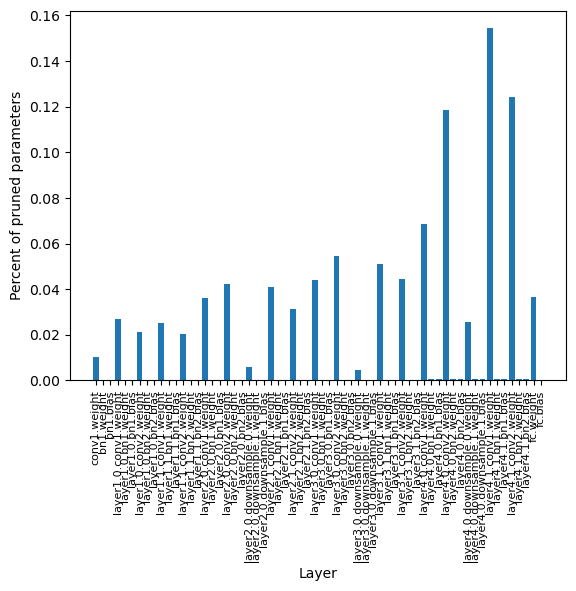

In [11]:
import matplotlib.pyplot as plt
mask_percent_dict = {}
for item in mask_final:
    mask_percent_dict[item] = torch.sum(mask_final[item]) / (num_params * (1-target_sparsity))
cur_sum = 0
xs = []
ys = []
for item in mask_percent_dict:
    num = mask_percent_dict[item].item()
    xs.append(item)
    ys.append(num)
plt.bar(xs, ys)
plt.xlabel("Layer")
plt.xticks(rotation='vertical', fontsize=8)
plt.ylabel("Percent of pruned parameters")

Text(0, 0.5, 'Percent of pruned parameters')

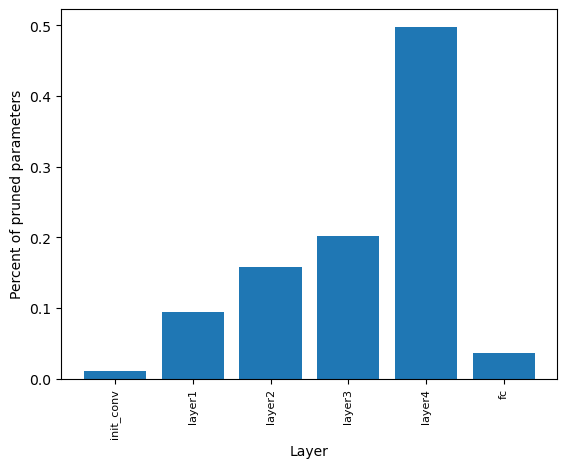

In [13]:
import matplotlib.pyplot as plt
mask_percent_dict = {}
for item in mask_final:
    mask_percent_dict[item] = torch.sum(mask_final[item]) / (num_params * (1-target_sparsity))
xs = ['init_conv', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
ys = {}
for item in xs:
    ys[item] = 0
count = 0
for item in mask_percent_dict:
    num = mask_percent_dict[item].item()
    if count < 3:
        ys['init_conv'] += num
    elif 'layer1' in item:
        ys['layer1'] += num
    elif 'layer2' in item:
        ys['layer2'] += num
    elif 'layer3' in item:
        ys['layer3'] += num
    elif 'layer4' in item:
        ys['layer4'] += num
    else:
        ys['fc'] += num
    count += 1
plt.bar(xs, list(ys.values()))
plt.xlabel("Layer")
plt.xticks(rotation='vertical', fontsize=8)
plt.ylabel("Percent of pruned parameters")

In [15]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 40
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
target_sparsity = 0.95
def var_no_train(shape):
    return torch.ones(shape, dtype=torch.float32, requires_grad=False).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
weights = model.state_dict()
mask_init = {k: var_no_train(weights[k].shape) for k in weights}
mask_prev = {k: var_no_train(weights[k].shape) for k in weights}
w_mask = apply_mask(weights, mask_init)

for inputs, labels in trainloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(inputs)
    loss = criterion(outputs, labels.float())
    model.zero_grad()
    loss.backward()
    absolute_gradients = {name: param.grad.abs() for name, param in model.named_parameters()}
    break

def restore(v, x_shape, sortkeys):
    split_sizes = []
    for key in sortkeys:
        split_sizes.append(functools.reduce(lambda x, y: x*y, x_shape[key]))
    v_splits = torch.split(v, split_size_or_sections=split_sizes)
    x_restore = {}
    for i, key in enumerate(sortkeys):
        x_restore.update({key: torch.reshape(v_splits[i], x_shape[key])})
    return x_restore
mask_v = torch.cat([absolute_gradients[k].view(-1) for k in absolute_gradients], dim=0)
x_shape = {k: absolute_gradients[k].shape for k in absolute_gradients}
restore_fn = functools.partial(restore, x_shape=x_shape, sortkeys=absolute_gradients)
num_params = mask_v.shape[0]
kappa = int(round(num_params * (1. - target_sparsity)))
ind = torch.randperm(num_params)[:kappa].to(DEVICE)
mask_sparse_v = torch.zeros_like(mask_v, dtype=torch.float32)
mask_sparse_v = mask_sparse_v.scatter_(0, ind, 1)
mask_final = restore_fn(mask_sparse_v)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=5
num_steps = 0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param, mask in zip(model.parameters(), mask_final):
                param.grad *= mask_final[mask]
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

  8%|█████████████▊                                                                                                                                                                 | 100/1272 [01:13<18:25,  1.06it/s]

0.7018157243728638


 16%|███████████████████████████▌                                                                                                                                                   | 200/1272 [02:26<16:40,  1.07it/s]

0.6469051241874695


 24%|█████████████████████████████████████████▎                                                                                                                                     | 300/1272 [03:39<15:19,  1.06it/s]

0.6119402050971985


 31%|███████████████████████████████████████████████████████                                                                                                                        | 400/1272 [04:53<13:50,  1.05it/s]

0.5745633244514465


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                          | 500/1272 [06:06<12:02,  1.07it/s]

0.547226071357727


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 600/1272 [07:19<10:35,  1.06it/s]

0.533835768699646


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 700/1272 [08:32<08:57,  1.06it/s]

0.5203456282615662


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 800/1272 [09:45<07:22,  1.07it/s]

0.5066784024238586


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 900/1272 [10:58<05:48,  1.07it/s]

0.5008455514907837


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1000/1272 [12:12<04:15,  1.07it/s]

0.4827289581298828


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1100/1272 [13:25<02:43,  1.05it/s]

0.4805009365081787


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1200/1272 [14:38<01:07,  1.06it/s]

0.4688413739204407


  2%|███▊                                                                                                                                                                            | 28/1272 [00:21<19:29,  1.06it/s]

0.4536534249782562


 10%|█████████████████▌                                                                                                                                                             | 128/1272 [01:34<18:06,  1.05it/s]

0.46180620789527893


 18%|███████████████████████████████▎                                                                                                                                               | 228/1272 [02:47<16:18,  1.07it/s]

0.45923614501953125


 26%|█████████████████████████████████████████████▏                                                                                                                                 | 328/1272 [04:00<14:46,  1.06it/s]

0.45860204100608826


 34%|██████████████████████████████████████████████████████████▉                                                                                                                    | 428/1272 [05:13<13:12,  1.06it/s]

0.4528074264526367


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                      | 528/1272 [06:27<11:40,  1.06it/s]

0.4402528703212738


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 628/1272 [07:40<10:10,  1.05it/s]

0.45097407698631287


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 728/1272 [08:53<08:31,  1.06it/s]

0.43825235962867737


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 828/1272 [10:06<06:59,  1.06it/s]

0.4436739981174469


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 928/1272 [11:19<05:20,  1.07it/s]

0.4369753897190094


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1028/1272 [12:32<03:50,  1.06it/s]

0.4333735406398773


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1128/1272 [13:46<02:16,  1.05it/s]

0.43564483523368835


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1228/1272 [14:59<00:41,  1.06it/s]

0.4273698925971985


  4%|███████▋                                                                                                                                                                        | 56/1272 [00:41<19:12,  1.05it/s]

0.4344828724861145


 12%|█████████████████████▍                                                                                                                                                         | 156/1272 [01:54<17:27,  1.07it/s]

0.4264417588710785


 20%|███████████████████████████████████▏                                                                                                                                           | 256/1272 [03:08<15:58,  1.06it/s]

0.4330576956272125


 28%|████████████████████████████████████████████████▉                                                                                                                              | 356/1272 [04:21<14:27,  1.06it/s]

0.43194037675857544


 36%|██████████████████████████████████████████████████████████████▋                                                                                                                | 456/1272 [05:34<12:42,  1.07it/s]

0.4279957413673401


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 556/1272 [06:47<11:19,  1.05it/s]

0.42285481095314026


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 656/1272 [08:00<09:40,  1.06it/s]

0.41361474990844727


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 756/1272 [09:13<08:07,  1.06it/s]

0.41720420122146606


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 856/1272 [10:27<06:30,  1.07it/s]

0.42415687441825867


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 956/1272 [11:40<04:55,  1.07it/s]

0.41037723422050476


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1056/1272 [12:53<03:24,  1.06it/s]

0.4171832203865051


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1156/1272 [14:06<01:49,  1.06it/s]

0.407828152179718


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1256/1272 [15:19<00:15,  1.06it/s]

0.41473299264907837


  7%|███████████▌                                                                                                                                                                    | 84/1272 [01:02<18:51,  1.05it/s]

0.41146889328956604


 14%|█████████████████████████▎                                                                                                                                                     | 184/1272 [02:15<17:06,  1.06it/s]

0.4129847586154938


 22%|███████████████████████████████████████                                                                                                                                        | 284/1272 [03:28<15:42,  1.05it/s]

0.4116806983947754


 30%|████████████████████████████████████████████████████▊                                                                                                                          | 384/1272 [04:41<13:56,  1.06it/s]

0.41792231798171997


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                            | 484/1272 [05:55<12:21,  1.06it/s]

0.4214768409729004


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 584/1272 [07:08<10:56,  1.05it/s]

0.4049483835697174


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 684/1272 [08:21<09:12,  1.06it/s]

0.41009005904197693


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 784/1272 [09:34<07:40,  1.06it/s]

0.3958143889904022


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 884/1272 [10:47<06:03,  1.07it/s]

0.40481072664260864


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 984/1272 [12:00<04:29,  1.07it/s]

0.4057522416114807


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1084/1272 [13:14<02:59,  1.05it/s]

0.41351744532585144


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1184/1272 [14:27<01:23,  1.06it/s]

0.41562968492507935


  1%|█▋                                                                                                                                                                              | 12/1272 [00:09<19:51,  1.06it/s]

0.4136228561401367


  9%|███████████████▍                                                                                                                                                               | 112/1272 [01:22<18:19,  1.05it/s]

0.4084291458129883


 17%|█████████████████████████████▏                                                                                                                                                 | 212/1272 [02:35<16:40,  1.06it/s]

0.3963874280452728


 25%|██████████████████████████████████████████▉                                                                                                                                    | 312/1272 [03:49<14:59,  1.07it/s]

0.41066232323646545


 32%|████████████████████████████████████████████████████████▋                                                                                                                      | 412/1272 [05:02<13:34,  1.06it/s]

0.391478031873703


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                        | 512/1272 [06:15<12:02,  1.05it/s]

0.396104097366333


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 612/1272 [07:28<10:22,  1.06it/s]

0.3963775932788849


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 712/1272 [08:41<08:49,  1.06it/s]

0.3842504620552063


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 812/1272 [09:54<07:12,  1.06it/s]

0.4056393802165985


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 912/1272 [11:07<05:40,  1.06it/s]

0.3896634876728058


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1012/1272 [12:21<04:05,  1.06it/s]

0.3983006179332733


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1112/1272 [13:34<02:30,  1.06it/s]

0.3853054642677307


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1212/1272 [14:47<00:56,  1.07it/s]

0.3920453190803528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1272/1272 [15:30<00:00,  1.37it/s]


In [16]:
def multi_label_accuracy(predictions, true_labels, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.

    Parameters:
    - predictions (Tensor): The output predictions from the model.
    - true_labels (Tensor): The actual labels.
    - threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
    - accuracy (float): The accuracy of the predictions.
    """
    # Applying sigmoid to convert logits to probabilities
    probs = torch.sigmoid(predictions)
    # Converting probabilities to binary predictions
    preds = probs > threshold
    # Comparing with true labels
    correct_predictions = (preds == true_labels).float()
    # Calculating accuracy
    accuracy = correct_predictions.sum() / correct_predictions.numel()
    return accuracy.item()

with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    total_accuracy = 0
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.float())
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        total_accuracy += multi_label_accuracy(outputs, labels)

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = total_accuracy / len(testloader)

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:45<00:00,  3.44it/s]

Validation Loss: 0.3964, Validation Accuracy: 0.8310


In [8]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 40
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
target_sparsity = 0.95
def var_no_train(shape):
    return torch.ones(shape, dtype=torch.float32, requires_grad=False).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
weights = model.state_dict()
mask_init = {k: var_no_train(weights[k].shape) for k in weights}
mask_prev = {k: var_no_train(weights[k].shape) for k in weights}
w_mask = apply_mask(weights, mask_init)

absolute_weights = {name: param for name, param in model.named_parameters()}

def restore(v, x_shape, sortkeys):
    split_sizes = []
    for key in sortkeys:
        split_sizes.append(functools.reduce(lambda x, y: x*y, x_shape[key]))
    v_splits = torch.split(v, split_size_or_sections=split_sizes)
    x_restore = {}
    for i, key in enumerate(sortkeys):
        x_restore.update({key: torch.reshape(v_splits[i], x_shape[key])})
    return x_restore
    
mask_v = torch.cat([absolute_weights[k].view(-1) for k in absolute_weights], dim=0)
x_shape = {k: absolute_weights[k].shape for k in absolute_weights}
restore_fn = functools.partial(restore, x_shape=x_shape, sortkeys=absolute_weights)
num_params = mask_v.shape[0]
kappa = int(round(num_params * (1. - target_sparsity)))
topk, ind = torch.topk(mask_v, k=kappa, largest=True, sorted=True)
mask_sparse_v = torch.zeros_like(mask_v, dtype=torch.float32)
mask_sparse_v = mask_sparse_v.scatter_(0, ind, 1)
mask_final = restore_fn(mask_sparse_v)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=5
num_steps = 0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param, mask in zip(model.parameters(), mask_final):
                param.grad *= mask_final[mask]
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

  8%|█████████████▊                                                                                                                                                                 | 100/1272 [01:13<18:26,  1.06it/s]

0.5770216584205627


 16%|███████████████████████████▌                                                                                                                                                   | 200/1272 [02:26<16:47,  1.06it/s]

0.5190756320953369


 24%|█████████████████████████████████████████▎                                                                                                                                     | 300/1272 [03:39<15:08,  1.07it/s]

0.4812658727169037


 31%|███████████████████████████████████████████████████████                                                                                                                        | 400/1272 [04:52<13:40,  1.06it/s]

0.46198055148124695


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                          | 500/1272 [06:05<12:15,  1.05it/s]

0.43556052446365356


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 600/1272 [07:19<10:30,  1.07it/s]

0.4463596045970917


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 700/1272 [08:32<08:57,  1.06it/s]

0.4462665021419525


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 800/1272 [09:45<07:29,  1.05it/s]

0.42739078402519226


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 900/1272 [10:58<05:53,  1.05it/s]

0.42665645480155945


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1000/1272 [12:11<04:15,  1.06it/s]

0.4192935526371002


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1100/1272 [13:24<02:43,  1.05it/s]

0.42964592576026917


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1200/1272 [14:37<01:07,  1.06it/s]

0.41647472977638245


  2%|███▊                                                                                                                                                                            | 28/1272 [00:21<19:18,  1.07it/s]

0.41669026017189026


 10%|█████████████████▌                                                                                                                                                             | 128/1272 [01:34<17:58,  1.06it/s]

0.41838884353637695


 18%|███████████████████████████████▎                                                                                                                                               | 228/1272 [02:47<16:20,  1.06it/s]

0.40878626704216003


 26%|█████████████████████████████████████████████▏                                                                                                                                 | 328/1272 [04:00<14:46,  1.06it/s]

0.4203428328037262


 34%|██████████████████████████████████████████████████████████▉                                                                                                                    | 428/1272 [05:14<13:19,  1.06it/s]

0.4023686349391937


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                      | 528/1272 [06:27<11:44,  1.06it/s]

0.4127933084964752


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 628/1272 [07:40<10:04,  1.07it/s]

0.4105348587036133


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 728/1272 [08:53<08:33,  1.06it/s]

0.39116647839546204


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 828/1272 [10:07<07:01,  1.05it/s]

0.40068569779396057


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 928/1272 [11:20<05:25,  1.06it/s]

0.39331838488578796


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1028/1272 [12:33<03:48,  1.07it/s]

0.4136806130409241


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1128/1272 [13:47<02:17,  1.05it/s]

0.40127119421958923


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1228/1272 [15:00<00:41,  1.07it/s]

0.40012797713279724


  4%|███████▋                                                                                                                                                                        | 56/1272 [00:41<19:06,  1.06it/s]

0.38954898715019226


 12%|█████████████████████▍                                                                                                                                                         | 156/1272 [01:55<17:35,  1.06it/s]

0.38390251994132996


 20%|███████████████████████████████████▏                                                                                                                                           | 256/1272 [03:08<15:55,  1.06it/s]

0.39728352427482605


 28%|████████████████████████████████████████████████▉                                                                                                                              | 356/1272 [04:22<14:15,  1.07it/s]

0.38822731375694275


 36%|██████████████████████████████████████████████████████████████▋                                                                                                                | 456/1272 [05:35<12:44,  1.07it/s]

0.3804604709148407


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 556/1272 [06:48<11:19,  1.05it/s]

0.38415083289146423


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 656/1272 [08:01<09:37,  1.07it/s]

0.3907066285610199


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 756/1272 [09:14<08:11,  1.05it/s]

0.38079413771629333


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 856/1272 [10:28<06:32,  1.06it/s]

0.38381272554397583


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 956/1272 [11:41<04:58,  1.06it/s]

0.3930012881755829


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1056/1272 [12:55<03:25,  1.05it/s]

0.3978009521961212


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1156/1272 [14:08<01:49,  1.06it/s]

0.3703346848487854


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1256/1272 [15:21<00:14,  1.07it/s]

0.37971004843711853


  7%|███████████▌                                                                                                                                                                    | 84/1272 [01:02<18:33,  1.07it/s]

0.3768690824508667


 14%|█████████████████████████▎                                                                                                                                                     | 184/1272 [02:15<17:03,  1.06it/s]

0.37405768036842346


 22%|███████████████████████████████████████                                                                                                                                        | 284/1272 [03:28<15:30,  1.06it/s]

0.3714424669742584


 30%|████████████████████████████████████████████████████▊                                                                                                                          | 384/1272 [04:41<14:04,  1.05it/s]

0.39743947982788086


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                            | 484/1272 [05:54<12:14,  1.07it/s]

0.3699045777320862


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 584/1272 [07:07<10:47,  1.06it/s]

0.3641830384731293


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 684/1272 [08:20<09:14,  1.06it/s]

0.36491498351097107


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 784/1272 [09:33<07:36,  1.07it/s]

0.356059730052948


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 884/1272 [10:46<06:03,  1.07it/s]

0.3666244149208069


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 984/1272 [11:59<04:30,  1.07it/s]

0.3694821894168854


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1084/1272 [13:12<02:56,  1.06it/s]

0.37068864703178406


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1184/1272 [14:25<01:22,  1.07it/s]

0.3540830612182617


  1%|█▋                                                                                                                                                                              | 12/1272 [00:09<19:47,  1.06it/s]

0.35035401582717896


  9%|███████████████▍                                                                                                                                                               | 112/1272 [01:22<18:05,  1.07it/s]

0.37740442156791687


 17%|█████████████████████████████▏                                                                                                                                                 | 212/1272 [02:35<16:38,  1.06it/s]

0.3543769419193268


 25%|██████████████████████████████████████████▉                                                                                                                                    | 312/1272 [03:48<15:03,  1.06it/s]

0.37839773297309875


 32%|████████████████████████████████████████████████████████▋                                                                                                                      | 412/1272 [05:01<13:35,  1.05it/s]

0.35701602697372437


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                        | 512/1272 [06:14<11:52,  1.07it/s]

0.3679680824279785


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 612/1272 [07:27<10:22,  1.06it/s]

0.3603850305080414


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 712/1272 [08:40<08:44,  1.07it/s]

0.3491942882537842


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 812/1272 [09:53<07:06,  1.08it/s]

0.3496738076210022


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 912/1272 [11:06<05:36,  1.07it/s]

0.35667896270751953


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1012/1272 [12:19<04:04,  1.06it/s]

0.3517293930053711


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1112/1272 [13:32<02:30,  1.06it/s]

0.34863701462745667


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1212/1272 [14:45<00:56,  1.07it/s]

0.35082340240478516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1272/1272 [15:28<00:00,  1.37it/s]


In [9]:
def multi_label_accuracy(predictions, true_labels, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.

    Parameters:
    - predictions (Tensor): The output predictions from the model.
    - true_labels (Tensor): The actual labels.
    - threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
    - accuracy (float): The accuracy of the predictions.
    """
    # Applying sigmoid to convert logits to probabilities
    probs = torch.sigmoid(predictions)
    # Converting probabilities to binary predictions
    preds = probs > threshold
    # Comparing with true labels
    correct_predictions = (preds == true_labels).float()
    # Calculating accuracy
    accuracy = correct_predictions.sum() / correct_predictions.numel()
    return accuracy.item()

with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    total_accuracy = 0
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.float())
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        total_accuracy += multi_label_accuracy(outputs, labels)

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = total_accuracy / len(testloader)

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:44<00:00,  3.48it/s]

Validation Loss: 0.3528, Validation Accuracy: 0.8464


In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
transform = transforms.Compose([
    transforms.Resize(224),  # Optional, depending on the model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=8)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer1' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|██████████▍                              | 100/391 [00:53<03:17,  1.47it/s]

2.1973326206207275


 51%|████████████████████▉                    | 200/391 [01:46<02:09,  1.47it/s]

2.1969785690307617


 77%|███████████████████████████████▍         | 300/391 [02:40<01:02,  1.45it/s]

2.170447826385498


  2%|▉                                          | 9/391 [00:05<04:26,  1.44it/s]

2.1853768825531006


 28%|███████████▍                             | 109/391 [00:58<03:11,  1.47it/s]

2.09214186668396


 53%|█████████████████████▉                   | 209/391 [01:52<02:04,  1.46it/s]

2.1189754009246826


 79%|████████████████████████████████▍        | 309/391 [02:45<00:56,  1.46it/s]

2.1033496856689453


  5%|█▉                                        | 18/391 [00:10<04:17,  1.45it/s]

2.08434796333313


 30%|████████████▎                            | 118/391 [01:03<03:07,  1.46it/s]

2.0620951652526855


 56%|██████████████████████▊                  | 218/391 [01:57<01:58,  1.46it/s]

2.042038679122925


 81%|█████████████████████████████████▎       | 318/391 [02:50<00:49,  1.47it/s]

1.9196019172668457


  7%|██▉                                       | 27/391 [00:15<04:12,  1.44it/s]

1.9961003065109253


 32%|█████████████▎                           | 127/391 [01:08<03:00,  1.46it/s]

1.9396822452545166


 58%|███████████████████████▊                 | 227/391 [02:01<01:50,  1.48it/s]

1.9484503269195557


 84%|██████████████████████████████████▎      | 327/391 [02:54<00:43,  1.46it/s]

1.9493190050125122


  9%|███▊                                      | 36/391 [00:19<04:05,  1.45it/s]

1.955480694770813


 35%|██████████████▎                          | 136/391 [01:13<02:56,  1.44it/s]

1.953462839126587


 60%|████████████████████████▋                | 236/391 [02:06<01:47,  1.45it/s]

1.914109230041504


 86%|███████████████████████████████████▏     | 336/391 [03:00<00:37,  1.47it/s]

1.8871275186538696


 12%|████▊                                     | 45/391 [00:24<03:57,  1.46it/s]

1.9006006717681885


 37%|███████████████▏                         | 145/391 [01:18<02:48,  1.46it/s]

1.903128981590271


 63%|█████████████████████████▋               | 245/391 [02:11<01:39,  1.47it/s]

1.8704735040664673


 88%|████████████████████████████████████▏    | 345/391 [03:04<00:31,  1.46it/s]

1.884674310684204


 14%|█████▊                                    | 54/391 [00:29<03:49,  1.47it/s]

1.7704282999038696


 39%|████████████████▏                        | 154/391 [01:22<02:44,  1.44it/s]

1.8196802139282227


 65%|██████████████████████████▋              | 254/391 [02:16<01:33,  1.46it/s]

1.7975231409072876


 91%|█████████████████████████████████████    | 354/391 [03:09<00:25,  1.47it/s]

1.8214720487594604


 16%|██████▊                                   | 63/391 [00:34<03:45,  1.46it/s]

1.779481053352356


 42%|█████████████████                        | 163/391 [01:27<02:35,  1.46it/s]

1.8893426656723022


 67%|███████████████████████████▌             | 263/391 [02:21<01:28,  1.45it/s]

1.728807806968689


 93%|██████████████████████████████████████   | 363/391 [03:14<00:19,  1.44it/s]

1.755326747894287


 18%|███████▋                                  | 72/391 [00:38<03:35,  1.48it/s]

1.8251160383224487


 44%|██████████████████                       | 172/391 [01:32<02:31,  1.44it/s]

1.835031509399414


 70%|████████████████████████████▌            | 272/391 [02:25<01:21,  1.47it/s]

1.8272647857666016


 95%|███████████████████████████████████████  | 372/391 [03:18<00:12,  1.46it/s]

1.7124948501586914


 21%|████████▋                                 | 81/391 [00:43<03:30,  1.48it/s]

1.7898427248001099


 46%|██████████████████▉                      | 181/391 [01:36<02:23,  1.46it/s]

1.774958610534668


 72%|█████████████████████████████▍           | 281/391 [02:30<01:15,  1.46it/s]

1.895851731300354


 97%|███████████████████████████████████████▉ | 381/391 [03:23<00:06,  1.46it/s]

1.8423588275909424


100%|█████████████████████████████████████████| 391/391 [03:28<00:00,  1.88it/s]


In [17]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|███████████████████████████████████████████| 79/79 [00:15<00:00,  5.20it/s]

Validation Loss: 1.7472, Validation Accuracy: 0.4539


In [18]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer2' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|██████████▍                              | 100/391 [00:54<03:21,  1.44it/s]

2.362804889678955


 51%|████████████████████▉                    | 200/391 [01:47<02:11,  1.46it/s]

2.2307417392730713


 77%|███████████████████████████████▍         | 300/391 [02:40<01:02,  1.46it/s]

2.1607539653778076


  2%|▉                                          | 9/391 [00:05<04:27,  1.43it/s]

2.0390915870666504


 28%|███████████▍                             | 109/391 [00:58<03:15,  1.44it/s]

2.067307949066162


 53%|█████████████████████▉                   | 209/391 [01:52<02:05,  1.45it/s]

1.9144293069839478


 79%|████████████████████████████████▍        | 309/391 [02:45<00:56,  1.45it/s]

2.031622886657715


  5%|█▉                                        | 18/391 [00:10<04:19,  1.44it/s]

1.937624216079712


 30%|████████████▎                            | 118/391 [01:03<03:05,  1.47it/s]

1.8497860431671143


 56%|██████████████████████▊                  | 218/391 [01:57<01:58,  1.46it/s]

1.8653132915496826


 81%|█████████████████████████████████▎       | 318/391 [02:50<00:49,  1.47it/s]

1.8204026222229004


  7%|██▉                                       | 27/391 [00:15<04:11,  1.44it/s]

1.789975881576538


 32%|█████████████▎                           | 127/391 [01:08<03:03,  1.44it/s]

1.7887165546417236


 58%|███████████████████████▊                 | 227/391 [02:01<01:52,  1.46it/s]

1.6517579555511475


 84%|██████████████████████████████████▎      | 327/391 [02:55<00:43,  1.47it/s]

1.7837400436401367


  9%|███▊                                      | 36/391 [00:19<04:03,  1.46it/s]

1.693384051322937


 35%|██████████████▎                          | 136/391 [01:13<02:55,  1.45it/s]

1.6059170961380005


 60%|████████████████████████▋                | 236/391 [02:06<01:44,  1.48it/s]

1.6940710544586182


 86%|███████████████████████████████████▏     | 336/391 [03:00<00:38,  1.44it/s]

1.6891194581985474


 12%|████▊                                     | 45/391 [00:24<03:56,  1.46it/s]

1.6204490661621094


 37%|███████████████▏                         | 145/391 [01:18<02:48,  1.46it/s]

1.4959267377853394


 63%|█████████████████████████▋               | 245/391 [02:11<01:40,  1.46it/s]

1.5395983457565308


 88%|████████████████████████████████████▏    | 345/391 [03:04<00:31,  1.44it/s]

1.5300403833389282


 14%|█████▊                                    | 54/391 [00:29<03:50,  1.46it/s]

1.4984194040298462


 39%|████████████████▏                        | 154/391 [01:23<02:43,  1.45it/s]

1.6185256242752075


 65%|██████████████████████████▋              | 254/391 [02:16<01:33,  1.46it/s]

1.6425329446792603


 91%|█████████████████████████████████████    | 354/391 [03:09<00:25,  1.47it/s]

1.53311288356781


 16%|██████▊                                   | 63/391 [00:34<03:45,  1.45it/s]

1.424999475479126


 42%|█████████████████                        | 163/391 [01:27<02:35,  1.46it/s]

1.3543157577514648


 67%|███████████████████████████▌             | 263/391 [02:21<01:28,  1.45it/s]

1.529664397239685


 93%|██████████████████████████████████████   | 363/391 [03:14<00:19,  1.44it/s]

1.4392797946929932


 18%|███████▋                                  | 72/391 [00:38<03:38,  1.46it/s]

1.4805209636688232


 44%|██████████████████                       | 172/391 [01:32<02:28,  1.48it/s]

1.3713046312332153


 70%|████████████████████████████▌            | 272/391 [02:25<01:21,  1.46it/s]

1.408735990524292


 95%|███████████████████████████████████████  | 372/391 [03:19<00:13,  1.44it/s]

1.4856466054916382


 21%|████████▋                                 | 81/391 [00:43<03:34,  1.44it/s]

1.3597497940063477


 46%|██████████████████▉                      | 181/391 [01:37<02:23,  1.47it/s]

1.437337875366211


 72%|█████████████████████████████▍           | 281/391 [02:30<01:15,  1.46it/s]

1.427875280380249


 97%|███████████████████████████████████████▉ | 381/391 [03:23<00:06,  1.45it/s]

1.347198247909546


100%|█████████████████████████████████████████| 391/391 [03:28<00:00,  1.87it/s]


In [19]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|███████████████████████████████████████████| 79/79 [00:15<00:00,  5.11it/s]

Validation Loss: 1.4104, Validation Accuracy: 0.5884


In [20]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer3' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|██████████▍                              | 100/391 [00:54<03:19,  1.46it/s]

2.2074849605560303


 51%|████████████████████▉                    | 200/391 [01:47<02:12,  1.45it/s]

2.0705533027648926


 77%|███████████████████████████████▍         | 300/391 [02:40<01:01,  1.48it/s]

1.7812281847000122


  2%|▉                                          | 9/391 [00:05<04:26,  1.43it/s]

1.7401219606399536


 28%|███████████▍                             | 109/391 [00:58<03:13,  1.46it/s]

1.6792280673980713


 53%|█████████████████████▉                   | 209/391 [01:51<02:04,  1.46it/s]

1.4941624402999878


 79%|████████████████████████████████▍        | 309/391 [02:45<00:56,  1.45it/s]

1.4873813390731812


  5%|█▉                                        | 18/391 [00:10<04:15,  1.46it/s]

1.312709927558899


 30%|████████████▎                            | 118/391 [01:03<03:07,  1.45it/s]

1.353354811668396


 56%|██████████████████████▊                  | 218/391 [01:57<01:57,  1.48it/s]

1.2108784914016724


 81%|█████████████████████████████████▎       | 318/391 [02:50<00:50,  1.46it/s]

1.0233333110809326


  7%|██▉                                       | 27/391 [00:15<04:12,  1.44it/s]

1.1462299823760986


 32%|█████████████▎                           | 127/391 [01:08<03:01,  1.45it/s]

1.0701061487197876


 58%|███████████████████████▊                 | 227/391 [02:01<01:53,  1.45it/s]

0.9987119436264038


 84%|██████████████████████████████████▎      | 327/391 [02:55<00:43,  1.49it/s]

1.0804805755615234


  9%|███▊                                      | 36/391 [00:19<04:03,  1.46it/s]

1.0127596855163574


 35%|██████████████▎                          | 136/391 [01:13<02:52,  1.48it/s]

0.9985156655311584


 60%|████████████████████████▋                | 236/391 [02:06<01:45,  1.46it/s]

0.9017596244812012


 86%|███████████████████████████████████▏     | 336/391 [02:59<00:38,  1.44it/s]

0.9828971028327942


 12%|████▊                                     | 45/391 [00:24<03:58,  1.45it/s]

0.9578935503959656


 37%|███████████████▏                         | 145/391 [01:17<02:47,  1.47it/s]

0.7852845191955566


 63%|█████████████████████████▋               | 245/391 [02:11<01:40,  1.46it/s]

0.9394593238830566


 88%|████████████████████████████████████▏    | 345/391 [03:04<00:31,  1.44it/s]

0.8574545383453369


 14%|█████▊                                    | 54/391 [00:29<03:51,  1.46it/s]

0.7815375328063965


 39%|████████████████▏                        | 154/391 [01:22<02:39,  1.48it/s]

0.7969425916671753


 65%|██████████████████████████▋              | 254/391 [02:15<01:34,  1.45it/s]

0.8556001782417297


 91%|█████████████████████████████████████    | 354/391 [03:08<00:25,  1.47it/s]

0.8223794102668762


 16%|██████▊                                   | 63/391 [00:34<03:41,  1.48it/s]

0.6521559953689575


 42%|█████████████████                        | 163/391 [01:27<02:38,  1.44it/s]

0.7380570769309998


 67%|███████████████████████████▌             | 263/391 [02:20<01:26,  1.47it/s]

0.6976390480995178


 93%|██████████████████████████████████████   | 363/391 [03:13<00:19,  1.46it/s]

0.7584930658340454


 18%|███████▋                                  | 72/391 [00:39<03:38,  1.46it/s]

0.733656644821167


 44%|██████████████████                       | 172/391 [01:32<02:30,  1.46it/s]

0.6781764030456543


 70%|████████████████████████████▌            | 272/391 [02:25<01:22,  1.45it/s]

0.686152994632721


 95%|███████████████████████████████████████  | 372/391 [03:18<00:13,  1.44it/s]

0.7314713597297668


 21%|████████▋                                 | 81/391 [00:44<03:36,  1.43it/s]

0.7072144746780396


 46%|██████████████████▉                      | 181/391 [01:37<02:25,  1.45it/s]

0.7565204501152039


 72%|█████████████████████████████▍           | 281/391 [02:30<01:14,  1.48it/s]

0.6760764718055725


 97%|███████████████████████████████████████▉ | 381/391 [03:24<00:06,  1.45it/s]

0.7059075236320496


100%|█████████████████████████████████████████| 391/391 [03:28<00:00,  1.87it/s]


In [21]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|███████████████████████████████████████████| 79/79 [00:15<00:00,  5.12it/s]

Validation Loss: 0.7185, Validation Accuracy: 0.8191


In [22]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer4' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|██████████▍                              | 100/391 [00:54<03:20,  1.45it/s]

1.359424352645874


 51%|████████████████████▉                    | 200/391 [01:47<02:12,  1.45it/s]

1.000941514968872


 77%|███████████████████████████████▍         | 300/391 [02:40<01:02,  1.47it/s]

0.9113597869873047


  2%|▉                                          | 9/391 [00:05<04:28,  1.42it/s]

0.6518929600715637


 28%|███████████▍                             | 109/391 [00:58<03:12,  1.46it/s]

0.7001197338104248


 53%|█████████████████████▉                   | 209/391 [01:52<02:05,  1.46it/s]

0.7060240507125854


 79%|████████████████████████████████▍        | 309/391 [02:45<00:56,  1.45it/s]

0.6914876103401184


  5%|█▉                                        | 18/391 [00:10<04:13,  1.47it/s]

0.5419690608978271


 30%|████████████▎                            | 118/391 [01:03<03:05,  1.47it/s]

0.41066208481788635


 56%|██████████████████████▊                  | 218/391 [01:56<01:59,  1.45it/s]

0.41399529576301575


 81%|█████████████████████████████████▎       | 318/391 [02:50<00:49,  1.47it/s]

0.4571882486343384


  7%|██▉                                       | 27/391 [00:14<04:08,  1.47it/s]

0.35284820199012756


 32%|█████████████▎                           | 127/391 [01:08<03:03,  1.44it/s]

0.40020057559013367


 58%|███████████████████████▊                 | 227/391 [02:01<01:51,  1.47it/s]

0.39189887046813965


 84%|██████████████████████████████████▎      | 327/391 [02:55<00:44,  1.45it/s]

0.43521955609321594


  9%|███▊                                      | 36/391 [00:19<04:04,  1.45it/s]

0.39639440178871155


 35%|██████████████▎                          | 136/391 [01:13<02:53,  1.47it/s]

0.3262023329734802


 60%|████████████████████████▋                | 236/391 [02:06<01:46,  1.45it/s]

0.41674235463142395


 86%|███████████████████████████████████▏     | 336/391 [02:59<00:37,  1.47it/s]

0.2822519838809967


 12%|████▊                                     | 45/391 [00:24<03:58,  1.45it/s]

0.3802708387374878


 37%|███████████████▏                         | 145/391 [01:18<02:49,  1.45it/s]

0.2674141526222229


 63%|█████████████████████████▋               | 245/391 [02:11<01:39,  1.46it/s]

0.3430889844894409


 88%|████████████████████████████████████▏    | 345/391 [03:04<00:31,  1.46it/s]

0.35330986976623535


 14%|█████▊                                    | 54/391 [00:29<03:52,  1.45it/s]

0.3204696774482727


 39%|████████████████▏                        | 154/391 [01:23<02:43,  1.45it/s]

0.3341335356235504


 65%|██████████████████████████▋              | 254/391 [02:16<01:33,  1.46it/s]

0.35258159041404724


 91%|█████████████████████████████████████    | 354/391 [03:09<00:25,  1.46it/s]

0.19838513433933258


 16%|██████▊                                   | 63/391 [00:34<03:46,  1.45it/s]

0.2888657748699188


 42%|█████████████████                        | 163/391 [01:27<02:34,  1.47it/s]

0.28619134426116943


 67%|███████████████████████████▌             | 263/391 [02:21<01:27,  1.46it/s]

0.29102692008018494


 93%|██████████████████████████████████████   | 363/391 [03:14<00:19,  1.46it/s]

0.23155835270881653


 18%|███████▋                                  | 72/391 [00:39<03:38,  1.46it/s]

0.26243647933006287


 44%|██████████████████                       | 172/391 [01:32<02:28,  1.47it/s]

0.29352518916130066


 70%|████████████████████████████▌            | 272/391 [02:25<01:21,  1.47it/s]

0.18913054466247559


 95%|███████████████████████████████████████  | 372/391 [03:19<00:13,  1.46it/s]

0.19961756467819214


 21%|████████▋                                 | 81/391 [00:43<03:29,  1.48it/s]

0.14803685247898102


 46%|██████████████████▉                      | 181/391 [01:37<02:23,  1.47it/s]

0.28080514073371887


 72%|█████████████████████████████▍           | 281/391 [02:30<01:15,  1.45it/s]

0.16259978711605072


 97%|███████████████████████████████████████▉ | 381/391 [03:23<00:06,  1.45it/s]

0.24355453252792358


100%|█████████████████████████████████████████| 391/391 [03:28<00:00,  1.88it/s]


In [23]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|███████████████████████████████████████████| 79/79 [00:15<00:00,  5.10it/s]

Validation Loss: 0.3401, Validation Accuracy: 0.8869


In [24]:
### CIFAR100 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
transform = transforms.Compose([
    transforms.Resize(224),  # Optional, depending on the model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainset = datasets.CIFAR100(root='./data2', train=True, download=False, transform=transform)
testset = datasets.CIFAR100(root='./data2', train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer1' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|██████████▍                              | 100/391 [00:54<03:19,  1.46it/s]

4.848519325256348


 51%|████████████████████▉                    | 200/391 [01:47<02:11,  1.45it/s]

4.6545305252075195


 77%|███████████████████████████████▍         | 300/391 [02:40<01:02,  1.45it/s]

4.724247455596924


  2%|▉                                          | 9/391 [00:05<04:26,  1.43it/s]

4.7739338874816895


 28%|███████████▍                             | 109/391 [00:58<03:12,  1.47it/s]

4.690638065338135


 53%|█████████████████████▉                   | 209/391 [01:51<02:05,  1.45it/s]

4.6310505867004395


 79%|████████████████████████████████▍        | 309/391 [02:45<00:56,  1.46it/s]

4.620601177215576


  5%|█▉                                        | 18/391 [00:10<04:18,  1.44it/s]

4.628810405731201


 30%|████████████▎                            | 118/391 [01:03<03:07,  1.46it/s]

4.619368553161621


 56%|██████████████████████▊                  | 218/391 [01:56<01:59,  1.45it/s]

4.598622798919678


 81%|█████████████████████████████████▎       | 318/391 [02:49<00:50,  1.44it/s]

4.524584770202637


  7%|██▉                                       | 27/391 [00:14<04:12,  1.44it/s]

4.62937593460083


 32%|█████████████▎                           | 127/391 [01:08<03:02,  1.45it/s]

4.584716320037842


 58%|███████████████████████▊                 | 227/391 [02:01<01:51,  1.47it/s]

4.627132892608643


 84%|██████████████████████████████████▎      | 327/391 [02:54<00:44,  1.44it/s]

4.575207710266113


  9%|███▊                                      | 36/391 [00:19<04:05,  1.45it/s]

4.585211277008057


 35%|██████████████▎                          | 136/391 [01:13<02:55,  1.46it/s]

4.569644927978516


 60%|████████████████████████▋                | 236/391 [02:06<01:47,  1.45it/s]

4.507641792297363


 86%|███████████████████████████████████▏     | 336/391 [02:59<00:37,  1.45it/s]

4.66457986831665


 12%|████▊                                     | 45/391 [00:24<03:58,  1.45it/s]

4.579626083374023


 37%|███████████████▏                         | 145/391 [01:17<02:48,  1.46it/s]

4.502115249633789


 63%|█████████████████████████▋               | 245/391 [02:11<01:39,  1.46it/s]

4.596257209777832


 88%|████████████████████████████████████▏    | 345/391 [03:04<00:31,  1.47it/s]

4.643874645233154


 14%|█████▊                                    | 54/391 [00:29<03:49,  1.47it/s]

4.544207572937012


 39%|████████████████▏                        | 154/391 [01:22<02:42,  1.46it/s]

4.573189735412598


 65%|██████████████████████████▋              | 254/391 [02:15<01:34,  1.46it/s]

4.57736873626709


 91%|█████████████████████████████████████    | 354/391 [03:08<00:25,  1.44it/s]

4.4987053871154785


 16%|██████▊                                   | 63/391 [00:34<03:42,  1.47it/s]

4.512720584869385


 42%|█████████████████                        | 163/391 [01:27<02:34,  1.47it/s]

4.465829372406006


 67%|███████████████████████████▌             | 263/391 [02:20<01:26,  1.48it/s]

4.416281700134277


 93%|██████████████████████████████████████   | 363/391 [03:14<00:19,  1.47it/s]

4.536471366882324


 18%|███████▋                                  | 72/391 [00:38<03:38,  1.46it/s]

4.52016019821167


 44%|██████████████████                       | 172/391 [01:32<02:31,  1.45it/s]

4.376026630401611


 70%|████████████████████████████▌            | 272/391 [02:25<01:21,  1.45it/s]

4.48499870300293


 95%|███████████████████████████████████████  | 372/391 [03:18<00:13,  1.46it/s]

4.419406414031982


 21%|████████▋                                 | 81/391 [00:43<03:31,  1.46it/s]

4.4029436111450195


 46%|██████████████████▉                      | 181/391 [01:36<02:24,  1.46it/s]

4.583810329437256


 72%|█████████████████████████████▍           | 281/391 [02:29<01:15,  1.46it/s]

4.431471347808838


 97%|███████████████████████████████████████▉ | 381/391 [03:23<00:06,  1.47it/s]

4.553535461425781


100%|█████████████████████████████████████████| 391/391 [03:28<00:00,  1.88it/s]


In [26]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|███████████████████████████████████████████| 79/79 [00:15<00:00,  5.24it/s]

Validation Loss: 4.5076, Validation Accuracy: 0.0504


In [27]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer2' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|██████████▍                              | 100/391 [00:53<03:18,  1.47it/s]

4.7387847900390625


 51%|████████████████████▉                    | 200/391 [01:46<02:11,  1.45it/s]

4.707949638366699


 77%|███████████████████████████████▍         | 300/391 [02:40<01:02,  1.45it/s]

4.695791721343994


  2%|▉                                          | 9/391 [00:05<04:25,  1.44it/s]

4.628551006317139


 28%|███████████▍                             | 109/391 [00:58<03:12,  1.46it/s]

4.629357814788818


 53%|█████████████████████▉                   | 209/391 [01:51<02:04,  1.46it/s]

4.672122955322266


 79%|████████████████████████████████▍        | 309/391 [02:45<00:55,  1.46it/s]

4.633201599121094


  5%|█▉                                        | 18/391 [00:10<04:17,  1.45it/s]

4.5524187088012695


 30%|████████████▎                            | 118/391 [01:03<03:08,  1.45it/s]

4.584898948669434


 56%|██████████████████████▊                  | 218/391 [01:56<02:00,  1.44it/s]

4.590042591094971


 81%|█████████████████████████████████▎       | 318/391 [02:50<00:50,  1.46it/s]

4.620882034301758


  7%|██▉                                       | 27/391 [00:14<04:10,  1.46it/s]

4.544765472412109


 32%|█████████████▎                           | 127/391 [01:08<03:01,  1.45it/s]

4.5830583572387695


 58%|███████████████████████▊                 | 227/391 [02:01<01:53,  1.44it/s]

4.4981842041015625


 84%|██████████████████████████████████▎      | 327/391 [02:54<00:43,  1.46it/s]

4.408130645751953


  9%|███▊                                      | 36/391 [00:19<04:06,  1.44it/s]

4.329102516174316


 35%|██████████████▎                          | 136/391 [01:12<02:55,  1.45it/s]

4.431070327758789


 60%|████████████████████████▋                | 236/391 [02:06<01:46,  1.46it/s]

4.322524547576904


 86%|███████████████████████████████████▏     | 336/391 [02:59<00:37,  1.46it/s]

4.366513252258301


 12%|████▊                                     | 45/391 [00:24<03:54,  1.48it/s]

4.274343013763428


 37%|███████████████▏                         | 145/391 [01:17<02:49,  1.45it/s]

4.41628360748291


 63%|█████████████████████████▋               | 245/391 [02:10<01:40,  1.45it/s]

4.276284217834473


 88%|████████████████████████████████████▏    | 345/391 [03:04<00:31,  1.44it/s]

4.29796838760376


 14%|█████▊                                    | 54/391 [00:29<03:50,  1.46it/s]

4.36777400970459


 39%|████████████████▏                        | 154/391 [01:22<02:43,  1.45it/s]

4.320152759552002


 65%|██████████████████████████▋              | 254/391 [02:16<01:35,  1.44it/s]

4.349125862121582


 91%|█████████████████████████████████████    | 354/391 [03:09<00:25,  1.45it/s]

4.40945291519165


 16%|██████▊                                   | 63/391 [00:34<03:45,  1.45it/s]

4.373453140258789


 42%|█████████████████                        | 163/391 [01:27<02:35,  1.47it/s]

4.494185924530029


 67%|███████████████████████████▌             | 263/391 [02:20<01:27,  1.46it/s]

4.377047538757324


 93%|██████████████████████████████████████   | 363/391 [03:14<00:19,  1.44it/s]

4.360715389251709


 18%|███████▋                                  | 72/391 [00:38<03:40,  1.45it/s]

4.274787902832031


 44%|██████████████████                       | 172/391 [01:32<02:30,  1.45it/s]

4.2799506187438965


 70%|████████████████████████████▌            | 272/391 [02:25<01:21,  1.47it/s]

4.281909465789795


 95%|███████████████████████████████████████  | 372/391 [03:18<00:12,  1.48it/s]

4.2845354080200195


 21%|████████▋                                 | 81/391 [00:43<03:33,  1.45it/s]

4.305624008178711


 46%|██████████████████▉                      | 181/391 [01:37<02:24,  1.46it/s]

4.148705005645752


 72%|█████████████████████████████▍           | 281/391 [02:30<01:15,  1.47it/s]

4.151590347290039


 97%|███████████████████████████████████████▉ | 381/391 [03:23<00:06,  1.44it/s]

4.262329578399658


100%|█████████████████████████████████████████| 391/391 [03:28<00:00,  1.87it/s]


In [28]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|███████████████████████████████████████████| 79/79 [00:15<00:00,  5.22it/s]

Validation Loss: 4.3114, Validation Accuracy: 0.0664


In [29]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer3' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|██████████▍                              | 100/391 [00:53<03:18,  1.47it/s]

4.729330539703369


 51%|████████████████████▉                    | 200/391 [01:47<02:10,  1.47it/s]

4.707377910614014


 77%|███████████████████████████████▍         | 300/391 [02:40<01:02,  1.45it/s]

4.671923637390137


  2%|▉                                          | 9/391 [00:05<04:21,  1.46it/s]

4.712325572967529


 28%|███████████▍                             | 109/391 [00:58<03:14,  1.45it/s]

4.56061315536499


 53%|█████████████████████▉                   | 209/391 [01:52<02:04,  1.46it/s]

4.560826778411865


 79%|████████████████████████████████▍        | 309/391 [02:45<00:55,  1.47it/s]

4.374852180480957


  5%|█▉                                        | 18/391 [00:10<04:18,  1.44it/s]

4.336307525634766


 30%|████████████▎                            | 118/391 [01:03<03:07,  1.46it/s]

4.363125801086426


 56%|██████████████████████▊                  | 218/391 [01:56<01:58,  1.46it/s]

4.300900936126709


 81%|█████████████████████████████████▎       | 318/391 [02:50<00:50,  1.45it/s]

4.213024139404297


  7%|██▉                                       | 27/391 [00:14<04:09,  1.46it/s]

4.21209716796875


 32%|█████████████▎                           | 127/391 [01:08<03:00,  1.46it/s]

4.210247993469238


 58%|███████████████████████▊                 | 227/391 [02:01<01:52,  1.46it/s]

4.027742385864258


 84%|██████████████████████████████████▎      | 327/391 [02:54<00:43,  1.48it/s]

4.084039211273193


  9%|███▊                                      | 36/391 [00:19<04:03,  1.46it/s]

4.196054935455322


 35%|██████████████▎                          | 136/391 [01:13<02:55,  1.45it/s]

4.057368755340576


 60%|████████████████████████▋                | 236/391 [02:06<01:45,  1.47it/s]

3.957637310028076


 86%|███████████████████████████████████▏     | 336/391 [03:00<00:38,  1.44it/s]

4.128305912017822


 12%|████▊                                     | 45/391 [00:24<03:56,  1.46it/s]

3.988111972808838


 37%|███████████████▏                         | 145/391 [01:17<02:49,  1.45it/s]

3.907644510269165


 63%|█████████████████████████▋               | 245/391 [02:11<01:40,  1.45it/s]

4.0161542892456055


 88%|████████████████████████████████████▏    | 345/391 [03:04<00:31,  1.45it/s]

3.819953441619873


 14%|█████▊                                    | 54/391 [00:29<03:49,  1.47it/s]

3.6458773612976074


 39%|████████████████▏                        | 154/391 [01:22<02:42,  1.46it/s]

3.827254295349121


 65%|██████████████████████████▋              | 254/391 [02:16<01:33,  1.46it/s]

3.7997965812683105


 91%|█████████████████████████████████████    | 354/391 [03:09<00:25,  1.44it/s]

3.69954776763916


 16%|██████▊                                   | 63/391 [00:34<03:48,  1.44it/s]

3.7730116844177246


 42%|█████████████████                        | 163/391 [01:27<02:35,  1.46it/s]

3.7852067947387695


 67%|███████████████████████████▌             | 263/391 [02:20<01:27,  1.46it/s]

3.8542654514312744


 93%|██████████████████████████████████████   | 363/391 [03:14<00:19,  1.45it/s]

3.53739595413208


 18%|███████▋                                  | 72/391 [00:38<03:35,  1.48it/s]

3.635221004486084


 44%|██████████████████                       | 172/391 [01:32<02:30,  1.45it/s]

3.763411045074463


 70%|████████████████████████████▌            | 272/391 [02:25<01:21,  1.45it/s]

3.70017147064209


 95%|███████████████████████████████████████  | 372/391 [03:19<00:12,  1.48it/s]

3.593635320663452


 21%|████████▋                                 | 81/391 [00:43<03:33,  1.45it/s]

3.7122063636779785


 46%|██████████████████▉                      | 181/391 [01:37<02:24,  1.46it/s]

3.497677803039551


 72%|█████████████████████████████▍           | 281/391 [02:30<01:16,  1.44it/s]

3.5860846042633057


 97%|███████████████████████████████████████▉ | 381/391 [03:23<00:06,  1.47it/s]

3.6710774898529053


100%|█████████████████████████████████████████| 391/391 [03:28<00:00,  1.87it/s]


In [30]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|███████████████████████████████████████████| 79/79 [00:15<00:00,  5.21it/s]

Validation Loss: 3.6603, Validation Accuracy: 0.2369


In [31]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=10
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer4' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

 26%|██████████▍                              | 100/391 [00:53<03:17,  1.48it/s]

4.610678195953369


 51%|████████████████████▉                    | 200/391 [01:46<02:08,  1.48it/s]

4.294582843780518


 77%|███████████████████████████████▍         | 300/391 [02:40<01:02,  1.45it/s]

3.925602674484253


  2%|▉                                          | 9/391 [00:05<04:22,  1.46it/s]

3.6626851558685303


 28%|███████████▍                             | 109/391 [00:58<03:13,  1.46it/s]

3.492696762084961


 53%|█████████████████████▉                   | 209/391 [01:51<02:05,  1.45it/s]

3.3446788787841797


 79%|████████████████████████████████▍        | 309/391 [02:45<00:55,  1.48it/s]

3.0182528495788574


  5%|█▉                                        | 18/391 [00:10<04:16,  1.45it/s]

2.928133726119995


 30%|████████████▎                            | 118/391 [01:03<03:05,  1.47it/s]

2.8162951469421387


 56%|██████████████████████▊                  | 218/391 [01:56<01:58,  1.46it/s]

2.811866283416748


 81%|█████████████████████████████████▎       | 318/391 [02:49<00:49,  1.47it/s]

2.8017914295196533


  7%|██▉                                       | 27/391 [00:14<04:06,  1.47it/s]

2.5842459201812744


 32%|█████████████▎                           | 127/391 [01:08<03:02,  1.44it/s]

2.6414546966552734


 58%|███████████████████████▊                 | 227/391 [02:01<01:51,  1.47it/s]

2.449291706085205


 84%|██████████████████████████████████▎      | 327/391 [02:54<00:43,  1.47it/s]

2.481524705886841


  9%|███▊                                      | 36/391 [00:19<04:03,  1.46it/s]

2.6575095653533936


 35%|██████████████▎                          | 136/391 [01:13<02:56,  1.45it/s]

2.3607306480407715


 60%|████████████████████████▋                | 236/391 [02:06<01:44,  1.48it/s]

2.2030527591705322


 86%|███████████████████████████████████▏     | 336/391 [02:59<00:37,  1.46it/s]

2.102316379547119


 12%|████▊                                     | 45/391 [00:24<03:57,  1.46it/s]

2.1987476348876953


 37%|███████████████▏                         | 145/391 [01:17<02:49,  1.45it/s]

2.2371609210968018


 63%|█████████████████████████▋               | 245/391 [02:11<01:39,  1.47it/s]

2.034085512161255


 88%|████████████████████████████████████▏    | 345/391 [03:04<00:31,  1.48it/s]

2.1219329833984375


 14%|█████▊                                    | 54/391 [00:29<03:50,  1.46it/s]

2.0290353298187256


 39%|████████████████▏                        | 154/391 [01:22<02:42,  1.46it/s]

1.9777659177780151


 65%|██████████████████████████▋              | 254/391 [02:15<01:33,  1.46it/s]

1.8469337224960327


 91%|█████████████████████████████████████    | 354/391 [03:09<00:25,  1.46it/s]

1.962384581565857


 16%|██████▊                                   | 63/391 [00:34<03:47,  1.44it/s]

1.86070716381073


 42%|█████████████████                        | 163/391 [01:27<02:36,  1.46it/s]

1.888241171836853


 67%|███████████████████████████▌             | 263/391 [02:20<01:27,  1.45it/s]

1.839484691619873


 93%|██████████████████████████████████████   | 363/391 [03:14<00:19,  1.44it/s]

1.8739969730377197


 18%|███████▋                                  | 72/391 [00:38<03:39,  1.46it/s]

1.7276301383972168


 44%|██████████████████                       | 172/391 [01:32<02:31,  1.45it/s]

1.8468085527420044


 70%|████████████████████████████▌            | 272/391 [02:25<01:21,  1.46it/s]

1.8159141540527344


 95%|███████████████████████████████████████  | 372/391 [03:18<00:13,  1.46it/s]

1.8662828207015991


 21%|████████▋                                 | 81/391 [00:43<03:29,  1.48it/s]

1.606820821762085


 46%|██████████████████▉                      | 181/391 [01:36<02:22,  1.47it/s]

1.554716944694519


 72%|█████████████████████████████▍           | 281/391 [02:30<01:16,  1.45it/s]

1.7386505603790283


 97%|███████████████████████████████████████▉ | 381/391 [03:23<00:06,  1.45it/s]

1.6040518283843994


100%|█████████████████████████████████████████| 391/391 [03:28<00:00,  1.88it/s]


In [32]:
with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = correct_predictions / total_predictions

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|███████████████████████████████████████████| 79/79 [00:15<00:00,  5.23it/s]

Validation Loss: 1.8118, Validation Accuracy: 0.6021


In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
transform = transforms.Compose([
    transforms.Resize(224),  # Optional, depending on the model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainset = datasets.CelebA(root='/home/mkolod/CS330Project/data3', split='train', download=False, transform=transform)
testset = datasets.CelebA(root='/home/mkolod/CS330Project/data3', split='test', download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 40
criterion = nn.BCEWithLogitsLoss()
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=5
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer1' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

  8%|███▏                                    | 100/1272 [01:13<17:58,  1.09it/s]

0.7052576541900635


 16%|██████▎                                 | 200/1272 [02:24<16:08,  1.11it/s]

0.6975997090339661


 24%|█████████▍                              | 300/1272 [03:36<14:52,  1.09it/s]

0.6979367136955261


 31%|████████████▌                           | 400/1272 [04:47<13:22,  1.09it/s]

0.6956571340560913


 39%|███████████████▋                        | 500/1272 [05:59<11:54,  1.08it/s]

0.6969999670982361


 47%|██████████████████▊                     | 600/1272 [07:10<10:23,  1.08it/s]

0.6976850628852844


 55%|██████████████████████                  | 700/1272 [08:21<08:42,  1.09it/s]

0.6992766261100769


 63%|█████████████████████████▏              | 800/1272 [09:33<07:14,  1.09it/s]

0.7036458849906921


 71%|████████████████████████████▎           | 900/1272 [10:44<05:42,  1.09it/s]

0.7040426135063171


 79%|██████████████████████████████▋        | 1000/1272 [11:55<04:07,  1.10it/s]

0.7032508850097656


 86%|█████████████████████████████████▋     | 1100/1272 [13:07<02:36,  1.10it/s]

0.7000831961631775


 94%|████████████████████████████████████▊  | 1200/1272 [14:18<01:05,  1.10it/s]

0.7010084986686707


  2%|▉                                        | 28/1272 [00:20<18:49,  1.10it/s]

0.6927291750907898


 10%|████                                    | 128/1272 [01:31<17:21,  1.10it/s]

0.6975834369659424


 18%|███████▏                                | 228/1272 [02:43<16:02,  1.08it/s]

0.6919809579849243


 26%|██████████▎                             | 328/1272 [03:54<14:38,  1.07it/s]

0.7008335590362549


 34%|█████████████▍                          | 428/1272 [05:05<12:52,  1.09it/s]

0.6946809887886047


 42%|████████████████▌                       | 528/1272 [06:17<11:25,  1.09it/s]

0.6917405128479004


 49%|███████████████████▋                    | 628/1272 [07:28<09:48,  1.09it/s]

0.6920369267463684


 57%|██████████████████████▉                 | 728/1272 [08:39<08:18,  1.09it/s]

0.6925646662712097


 65%|██████████████████████████              | 828/1272 [09:51<06:44,  1.10it/s]

0.6968308687210083


 73%|█████████████████████████████▏          | 928/1272 [11:02<05:15,  1.09it/s]

0.6943298578262329


 81%|███████████████████████████████▌       | 1028/1272 [12:13<03:44,  1.09it/s]

0.697609007358551


 89%|██████████████████████████████████▌    | 1128/1272 [13:24<02:12,  1.08it/s]

0.6904630064964294


 97%|█████████████████████████████████████▋ | 1228/1272 [14:36<00:40,  1.09it/s]

0.6984508633613586


  4%|█▊                                       | 56/1272 [00:40<18:35,  1.09it/s]

0.6889879703521729


 12%|████▉                                   | 156/1272 [01:51<17:01,  1.09it/s]

0.6934415102005005


 20%|████████                                | 256/1272 [03:03<15:34,  1.09it/s]

0.6932658553123474


 28%|███████████▏                            | 356/1272 [04:14<13:55,  1.10it/s]

0.6969607472419739


 36%|██████████████▎                         | 456/1272 [05:25<12:24,  1.10it/s]

0.6909079551696777


 44%|█████████████████▍                      | 556/1272 [06:36<10:54,  1.09it/s]

0.7034204006195068


 52%|████████████████████▋                   | 656/1272 [07:48<09:27,  1.08it/s]

0.6932994723320007


 59%|███████████████████████▊                | 756/1272 [08:59<07:50,  1.10it/s]

0.6946415305137634


 67%|██████████████████████████▉             | 856/1272 [10:10<06:22,  1.09it/s]

0.692523181438446


 75%|██████████████████████████████          | 956/1272 [11:21<04:49,  1.09it/s]

0.68760746717453


 83%|████████████████████████████████▍      | 1056/1272 [12:33<03:16,  1.10it/s]

0.6948314905166626


 91%|███████████████████████████████████▍   | 1156/1272 [13:44<01:46,  1.09it/s]

0.6925058364868164


 99%|██████████████████████████████████████▌| 1256/1272 [14:55<00:14,  1.09it/s]

0.6865778565406799


  7%|██▋                                      | 84/1272 [01:00<18:12,  1.09it/s]

0.6864284873008728


 14%|█████▊                                  | 184/1272 [02:11<16:41,  1.09it/s]

0.697645902633667


 22%|████████▉                               | 284/1272 [03:23<15:15,  1.08it/s]

0.6862626075744629


 30%|████████████                            | 384/1272 [04:34<13:37,  1.09it/s]

0.693789005279541


 38%|███████████████▏                        | 484/1272 [05:46<12:13,  1.08it/s]

0.6891067624092102


 46%|██████████████████▎                     | 584/1272 [06:57<10:31,  1.09it/s]

0.6910786032676697


 54%|█████████████████████▌                  | 684/1272 [08:08<08:54,  1.10it/s]

0.6864592432975769


 62%|████████████████████████▋               | 784/1272 [09:20<07:27,  1.09it/s]

0.6855365037918091


 69%|███████████████████████████▊            | 884/1272 [10:31<05:59,  1.08it/s]

0.6860975623130798


 77%|██████████████████████████████▉         | 984/1272 [11:43<04:25,  1.08it/s]

0.6842287182807922


 85%|█████████████████████████████████▏     | 1084/1272 [12:54<02:52,  1.09it/s]

0.6891571283340454


 93%|████████████████████████████████████▎  | 1184/1272 [14:06<01:21,  1.08it/s]

0.6863966584205627


  1%|▍                                        | 12/1272 [00:09<19:30,  1.08it/s]

0.6911665797233582


  9%|███▌                                    | 112/1272 [01:20<17:53,  1.08it/s]

0.6902866363525391


 17%|██████▋                                 | 212/1272 [02:31<16:20,  1.08it/s]

0.6916567087173462


 25%|█████████▊                              | 312/1272 [03:43<14:39,  1.09it/s]

0.686115026473999


 32%|████████████▉                           | 412/1272 [04:54<13:03,  1.10it/s]

0.6851460933685303


 40%|████████████████                        | 512/1272 [06:05<11:44,  1.08it/s]

0.6799694299697876


 48%|███████████████████▏                    | 612/1272 [07:17<10:11,  1.08it/s]

0.6833330988883972


 56%|██████████████████████▍                 | 712/1272 [08:28<08:39,  1.08it/s]

0.6846157908439636


 64%|█████████████████████████▌              | 812/1272 [09:39<07:03,  1.09it/s]

0.6855646371841431


 72%|████████████████████████████▋           | 912/1272 [10:51<05:31,  1.09it/s]

0.6824154853820801


 80%|███████████████████████████████        | 1012/1272 [12:02<04:00,  1.08it/s]

0.6808910369873047


 87%|██████████████████████████████████     | 1112/1272 [13:13<02:28,  1.08it/s]

0.6840159296989441


 95%|█████████████████████████████████████▏ | 1212/1272 [14:25<00:55,  1.09it/s]

0.6828079223632812


100%|███████████████████████████████████████| 1272/1272 [15:07<00:00,  1.40it/s]


In [35]:
def multi_label_accuracy(predictions, true_labels, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.

    Parameters:
    - predictions (Tensor): The output predictions from the model.
    - true_labels (Tensor): The actual labels.
    - threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
    - accuracy (float): The accuracy of the predictions.
    """
    # Applying sigmoid to convert logits to probabilities
    probs = torch.sigmoid(predictions)
    # Converting probabilities to binary predictions
    preds = probs > threshold
    # Comparing with true labels
    correct_predictions = (preds == true_labels).float()
    # Calculating accuracy
    accuracy = correct_predictions.sum() / correct_predictions.numel()
    return accuracy.item()

with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    total_accuracy = 0
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.float())
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        total_accuracy += multi_label_accuracy(outputs, labels)

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = total_accuracy / len(testloader)

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|█████████████████████████████████████████| 156/156 [00:43<00:00,  3.56it/s]

Validation Loss: 0.6885, Validation Accuracy: 0.5626


In [6]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 40
criterion = nn.BCEWithLogitsLoss()
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=5
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer2' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

  8%|███▏                                    | 100/1272 [01:13<17:58,  1.09it/s]

0.731360137462616


 16%|██████▎                                 | 200/1272 [02:25<16:31,  1.08it/s]

0.7328981161117554


 24%|█████████▍                              | 300/1272 [03:37<14:57,  1.08it/s]

0.737978994846344


 31%|████████████▌                           | 400/1272 [04:48<13:21,  1.09it/s]

0.7347385287284851


 39%|███████████████▋                        | 500/1272 [06:00<11:56,  1.08it/s]

0.7337986826896667


 47%|██████████████████▊                     | 600/1272 [07:12<10:19,  1.09it/s]

0.7298786044120789


 55%|██████████████████████                  | 700/1272 [08:24<08:50,  1.08it/s]

0.7327549457550049


 63%|█████████████████████████▏              | 800/1272 [09:35<07:15,  1.08it/s]

0.7285136580467224


 71%|████████████████████████████▎           | 900/1272 [10:47<05:43,  1.08it/s]

0.7298752069473267


 79%|██████████████████████████████▋        | 1000/1272 [11:59<04:09,  1.09it/s]

0.7283282279968262


 86%|█████████████████████████████████▋     | 1100/1272 [13:11<02:38,  1.09it/s]

0.7324581146240234


 94%|████████████████████████████████████▊  | 1200/1272 [14:23<01:06,  1.09it/s]

0.7350513339042664


  2%|▉                                        | 28/1272 [00:20<19:06,  1.08it/s]

0.7339470982551575


 10%|████                                    | 128/1272 [01:32<17:39,  1.08it/s]

0.7277516722679138


 18%|███████▏                                | 228/1272 [02:43<15:59,  1.09it/s]

0.730778157711029


 26%|██████████▎                             | 328/1272 [03:55<14:28,  1.09it/s]

0.7303469777107239


 34%|█████████████▍                          | 428/1272 [05:07<13:04,  1.08it/s]

0.7292113900184631


 42%|████████████████▌                       | 528/1272 [06:19<11:30,  1.08it/s]

0.7361354231834412


 49%|███████████████████▋                    | 628/1272 [07:30<09:50,  1.09it/s]

0.7268096804618835


 57%|██████████████████████▉                 | 728/1272 [08:42<08:20,  1.09it/s]

0.7339460849761963


 65%|██████████████████████████              | 828/1272 [09:54<06:47,  1.09it/s]

0.7277634739875793


 73%|█████████████████████████████▏          | 928/1272 [11:06<05:18,  1.08it/s]

0.734050452709198


 81%|███████████████████████████████▌       | 1028/1272 [12:18<03:46,  1.08it/s]

0.7332393527030945


 89%|██████████████████████████████████▌    | 1128/1272 [13:29<02:14,  1.07it/s]

0.7287163138389587


 97%|█████████████████████████████████████▋ | 1228/1272 [14:41<00:40,  1.08it/s]

0.7294014096260071


  4%|█▊                                       | 56/1272 [00:40<18:44,  1.08it/s]

0.7280003428459167


 12%|████▉                                   | 156/1272 [01:52<16:57,  1.10it/s]

0.7326866984367371


 20%|████████                                | 256/1272 [03:04<15:39,  1.08it/s]

0.723783016204834


 28%|███████████▏                            | 356/1272 [04:16<14:10,  1.08it/s]

0.7325051426887512


 36%|██████████████▎                         | 456/1272 [05:28<12:37,  1.08it/s]

0.7307568192481995


 44%|█████████████████▍                      | 556/1272 [06:39<11:04,  1.08it/s]

0.7306938171386719


 52%|████████████████████▋                   | 656/1272 [07:51<09:31,  1.08it/s]

0.726203203201294


 59%|███████████████████████▊                | 756/1272 [09:03<07:59,  1.08it/s]

0.7342931032180786


 67%|██████████████████████████▉             | 856/1272 [10:14<06:24,  1.08it/s]

0.7229812145233154


 75%|██████████████████████████████          | 956/1272 [11:26<04:53,  1.08it/s]

0.7244997620582581


 83%|████████████████████████████████▍      | 1056/1272 [12:38<03:18,  1.09it/s]

0.7221680283546448


 91%|███████████████████████████████████▍   | 1156/1272 [13:50<01:46,  1.08it/s]

0.7287774085998535


 99%|██████████████████████████████████████▌| 1256/1272 [15:01<00:14,  1.08it/s]

0.733766496181488


  7%|██▋                                      | 84/1272 [01:00<18:24,  1.08it/s]

0.7217713594436646


 14%|█████▊                                  | 184/1272 [02:12<16:44,  1.08it/s]

0.7189885973930359


 22%|████████▉                               | 284/1272 [03:24<15:16,  1.08it/s]

0.7173333168029785


 30%|████████████                            | 384/1272 [04:36<13:40,  1.08it/s]

0.7181685566902161


 38%|███████████████▏                        | 484/1272 [05:47<12:10,  1.08it/s]

0.7259735465049744


 46%|██████████████████▎                     | 584/1272 [06:59<10:36,  1.08it/s]

0.7213580012321472


 54%|█████████████████████▌                  | 684/1272 [08:11<09:06,  1.08it/s]

0.7195152044296265


 62%|████████████████████████▋               | 784/1272 [09:23<07:31,  1.08it/s]

0.7180230021476746


 69%|███████████████████████████▊            | 884/1272 [10:35<05:58,  1.08it/s]

0.7212440967559814


 77%|██████████████████████████████▉         | 984/1272 [11:47<04:26,  1.08it/s]

0.7215248346328735


 85%|█████████████████████████████████▏     | 1084/1272 [12:58<02:54,  1.08it/s]

0.7183101773262024


 93%|████████████████████████████████████▎  | 1184/1272 [14:10<01:21,  1.08it/s]

0.7297835350036621


  1%|▍                                        | 12/1272 [00:09<19:28,  1.08it/s]

0.7202613949775696


  9%|███▌                                    | 112/1272 [01:20<17:44,  1.09it/s]

0.7218664884567261


 17%|██████▋                                 | 212/1272 [02:32<16:24,  1.08it/s]

0.7165579199790955


 25%|█████████▊                              | 312/1272 [03:44<14:47,  1.08it/s]

0.7206866145133972


 32%|████████████▉                           | 412/1272 [04:56<13:14,  1.08it/s]

0.7212815880775452


 40%|████████████████                        | 512/1272 [06:08<11:43,  1.08it/s]

0.7195772528648376


 48%|███████████████████▏                    | 612/1272 [07:19<10:08,  1.08it/s]

0.7217242121696472


 56%|██████████████████████▍                 | 712/1272 [08:31<08:39,  1.08it/s]

0.7196478843688965


 64%|█████████████████████████▌              | 812/1272 [09:43<07:05,  1.08it/s]

0.7219008803367615


 72%|████████████████████████████▋           | 912/1272 [10:55<05:34,  1.08it/s]

0.7143810391426086


 80%|███████████████████████████████        | 1012/1272 [12:06<03:59,  1.09it/s]

0.7127000689506531


 87%|██████████████████████████████████     | 1112/1272 [13:18<02:28,  1.08it/s]

0.7190719842910767


 95%|█████████████████████████████████████▏ | 1212/1272 [14:30<00:55,  1.08it/s]

0.7217950820922852


100%|███████████████████████████████████████| 1272/1272 [15:13<00:00,  1.39it/s]


In [7]:
def multi_label_accuracy(predictions, true_labels, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.

    Parameters:
    - predictions (Tensor): The output predictions from the model.
    - true_labels (Tensor): The actual labels.
    - threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
    - accuracy (float): The accuracy of the predictions.
    """
    # Applying sigmoid to convert logits to probabilities
    probs = torch.sigmoid(predictions)
    # Converting probabilities to binary predictions
    preds = probs > threshold
    # Comparing with true labels
    correct_predictions = (preds == true_labels).float()
    # Calculating accuracy
    accuracy = correct_predictions.sum() / correct_predictions.numel()
    return accuracy.item()

with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    total_accuracy = 0
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.float())
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        total_accuracy += multi_label_accuracy(outputs, labels)

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = total_accuracy / len(testloader)

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|█████████████████████████████████████████| 156/156 [00:43<00:00,  3.57it/s]

Validation Loss: 0.7198, Validation Accuracy: 0.5118


In [8]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 40
criterion = nn.BCEWithLogitsLoss()
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=5
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer3' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

  8%|███▏                                    | 100/1272 [01:12<18:05,  1.08it/s]

0.7151984572410583


 16%|██████▎                                 | 200/1272 [02:24<16:32,  1.08it/s]

0.7073045372962952


 24%|█████████▍                              | 300/1272 [03:35<14:48,  1.09it/s]

0.7082514762878418


 31%|████████████▌                           | 400/1272 [04:47<13:27,  1.08it/s]

0.7130699157714844


 39%|███████████████▋                        | 500/1272 [05:59<11:55,  1.08it/s]

0.7082160115242004


 47%|██████████████████▊                     | 600/1272 [07:11<10:20,  1.08it/s]

0.7065610885620117


 55%|██████████████████████                  | 700/1272 [08:22<08:49,  1.08it/s]

0.7112314105033875


 63%|█████████████████████████▏              | 800/1272 [09:34<07:17,  1.08it/s]

0.7113884091377258


 71%|████████████████████████████▎           | 900/1272 [10:46<05:47,  1.07it/s]

0.7048248052597046


 79%|██████████████████████████████▋        | 1000/1272 [11:58<04:13,  1.07it/s]

0.6961406469345093


 86%|█████████████████████████████████▋     | 1100/1272 [13:10<02:39,  1.08it/s]

0.7050383687019348


 94%|████████████████████████████████████▊  | 1200/1272 [14:21<01:06,  1.09it/s]

0.6988176107406616


  2%|▉                                        | 28/1272 [00:20<19:13,  1.08it/s]

0.6964898109436035


 10%|████                                    | 128/1272 [01:32<17:40,  1.08it/s]

0.6975392699241638


 18%|███████▏                                | 228/1272 [02:44<15:58,  1.09it/s]

0.6968808174133301


 26%|██████████▎                             | 328/1272 [03:56<14:32,  1.08it/s]

0.6994442939758301


 34%|█████████████▍                          | 428/1272 [05:07<12:56,  1.09it/s]

0.6951665878295898


 42%|████████████████▌                       | 528/1272 [06:19<11:29,  1.08it/s]

0.6962675452232361


 49%|███████████████████▋                    | 628/1272 [07:31<09:52,  1.09it/s]

0.6942290663719177


 57%|██████████████████████▉                 | 728/1272 [08:42<08:22,  1.08it/s]

0.691218376159668


 65%|██████████████████████████              | 828/1272 [09:54<06:55,  1.07it/s]

0.6944052577018738


 73%|█████████████████████████████▏          | 928/1272 [11:06<05:16,  1.09it/s]

0.6893384456634521


 81%|███████████████████████████████▌       | 1028/1272 [12:18<03:47,  1.07it/s]

0.6831132173538208


 89%|██████████████████████████████████▌    | 1128/1272 [13:30<02:14,  1.07it/s]

0.6905471086502075


 97%|█████████████████████████████████████▋ | 1228/1272 [14:41<00:40,  1.08it/s]

0.6845447421073914


  4%|█▊                                       | 56/1272 [00:40<18:41,  1.08it/s]

0.6828414797782898


 12%|████▉                                   | 156/1272 [01:52<17:04,  1.09it/s]

0.6766314506530762


 20%|████████                                | 256/1272 [03:04<15:43,  1.08it/s]

0.682003378868103


 28%|███████████▏                            | 356/1272 [04:15<14:02,  1.09it/s]

0.6832486987113953


 36%|██████████████▎                         | 456/1272 [05:27<12:33,  1.08it/s]

0.6804457902908325


 44%|█████████████████▍                      | 556/1272 [06:39<11:01,  1.08it/s]

0.6808448433876038


 52%|████████████████████▋                   | 656/1272 [07:50<09:28,  1.08it/s]

0.6720808148384094


 59%|███████████████████████▊                | 756/1272 [09:02<07:51,  1.09it/s]

0.6776983737945557


 67%|██████████████████████████▉             | 856/1272 [10:14<06:24,  1.08it/s]

0.6766629219055176


 75%|██████████████████████████████          | 956/1272 [11:25<04:49,  1.09it/s]

0.672951877117157


 83%|████████████████████████████████▍      | 1056/1272 [12:37<03:20,  1.08it/s]

0.6749382019042969


 91%|███████████████████████████████████▍   | 1156/1272 [13:48<01:46,  1.08it/s]

0.6733306050300598


 99%|██████████████████████████████████████▌| 1256/1272 [15:00<00:14,  1.08it/s]

0.6699709892272949


  7%|██▋                                      | 84/1272 [01:00<18:12,  1.09it/s]

0.672773003578186


 14%|█████▊                                  | 184/1272 [02:12<16:41,  1.09it/s]

0.6687684059143066


 22%|████████▉                               | 284/1272 [03:24<15:09,  1.09it/s]

0.6695430874824524


 30%|████████████                            | 384/1272 [04:35<13:40,  1.08it/s]

0.6645147204399109


 38%|███████████████▏                        | 484/1272 [05:47<11:59,  1.09it/s]

0.6687655448913574


 46%|██████████████████▎                     | 584/1272 [06:58<10:29,  1.09it/s]

0.6649143099784851


 54%|█████████████████████▌                  | 684/1272 [08:10<09:00,  1.09it/s]

0.6603063344955444


 62%|████████████████████████▋               | 784/1272 [09:21<07:27,  1.09it/s]

0.6676652431488037


 69%|███████████████████████████▊            | 884/1272 [10:33<06:00,  1.08it/s]

0.656599223613739


 77%|██████████████████████████████▉         | 984/1272 [11:44<04:25,  1.09it/s]

0.6639209985733032


 85%|█████████████████████████████████▏     | 1084/1272 [12:56<02:52,  1.09it/s]

0.6645910143852234


 93%|████████████████████████████████████▎  | 1184/1272 [14:07<01:20,  1.09it/s]

0.6589456796646118


  1%|▍                                        | 12/1272 [00:09<19:29,  1.08it/s]

0.6624280214309692


  9%|███▌                                    | 112/1272 [01:20<17:52,  1.08it/s]

0.6580235362052917


 17%|██████▋                                 | 212/1272 [02:32<16:23,  1.08it/s]

0.6544310450553894


 25%|█████████▊                              | 312/1272 [03:43<14:51,  1.08it/s]

0.6535903811454773


 32%|████████████▉                           | 412/1272 [04:55<13:08,  1.09it/s]

0.6584335565567017


 40%|████████████████                        | 512/1272 [06:06<11:46,  1.08it/s]

0.6471495032310486


 48%|███████████████████▏                    | 612/1272 [07:17<10:07,  1.09it/s]

0.6593716144561768


 56%|██████████████████████▍                 | 712/1272 [08:28<08:38,  1.08it/s]

0.6555986404418945


 64%|█████████████████████████▌              | 812/1272 [09:40<07:00,  1.09it/s]

0.6530508399009705


 72%|████████████████████████████▋           | 912/1272 [10:51<05:26,  1.10it/s]

0.6561471819877625


 80%|███████████████████████████████        | 1012/1272 [12:03<03:58,  1.09it/s]

0.6550154089927673


 87%|██████████████████████████████████     | 1112/1272 [13:14<02:27,  1.08it/s]

0.6572311520576477


 95%|█████████████████████████████████████▏ | 1212/1272 [14:25<00:55,  1.08it/s]

0.6529980897903442


100%|███████████████████████████████████████| 1272/1272 [15:07<00:00,  1.40it/s]


In [9]:
def multi_label_accuracy(predictions, true_labels, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.

    Parameters:
    - predictions (Tensor): The output predictions from the model.
    - true_labels (Tensor): The actual labels.
    - threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
    - accuracy (float): The accuracy of the predictions.
    """
    # Applying sigmoid to convert logits to probabilities
    probs = torch.sigmoid(predictions)
    # Converting probabilities to binary predictions
    preds = probs > threshold
    # Comparing with true labels
    correct_predictions = (preds == true_labels).float()
    # Calculating accuracy
    accuracy = correct_predictions.sum() / correct_predictions.numel()
    return accuracy.item()

with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    total_accuracy = 0
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.float())
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        total_accuracy += multi_label_accuracy(outputs, labels)

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = total_accuracy / len(testloader)

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|█████████████████████████████████████████| 156/156 [00:43<00:00,  3.58it/s]

Validation Loss: 0.6521, Validation Accuracy: 0.6113


In [10]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
num_ftrs = model.fc.in_features
num_classes = 40
criterion = nn.BCEWithLogitsLoss()
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # or any other optimizer
num_epochs=5
num_steps=0
for epoch in range(num_epochs):
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if 'layer4' not in name:
                    param.grad *= 0
        optimizer.step()
        num_steps += 1
        if num_steps % 100 == 0:
            print(loss.item())

  8%|███▏                                    | 100/1272 [01:11<17:54,  1.09it/s]

0.751643180847168


 16%|██████▎                                 | 200/1272 [02:23<16:14,  1.10it/s]

0.7545060515403748


 24%|█████████▍                              | 300/1272 [03:34<14:54,  1.09it/s]

0.7406222820281982


 31%|████████████▌                           | 400/1272 [04:46<13:17,  1.09it/s]

0.7346348762512207


 39%|███████████████▋                        | 500/1272 [05:57<11:49,  1.09it/s]

0.7226722836494446


 47%|██████████████████▊                     | 600/1272 [07:08<10:22,  1.08it/s]

0.7194986343383789


 55%|██████████████████████                  | 700/1272 [08:19<08:44,  1.09it/s]

0.7244879603385925


 63%|█████████████████████████▏              | 800/1272 [09:30<07:14,  1.09it/s]

0.7121609449386597


 71%|████████████████████████████▎           | 900/1272 [10:42<05:42,  1.09it/s]

0.7038147449493408


 79%|██████████████████████████████▋        | 1000/1272 [11:53<04:11,  1.08it/s]

0.6978341341018677


 86%|█████████████████████████████████▋     | 1100/1272 [13:04<02:38,  1.09it/s]

0.6991626620292664


 94%|████████████████████████████████████▊  | 1200/1272 [14:16<01:06,  1.08it/s]

0.6910383105278015


  2%|▉                                        | 28/1272 [00:20<18:59,  1.09it/s]

0.6769015192985535


 10%|████                                    | 128/1272 [01:31<17:25,  1.09it/s]

0.6768726706504822


 18%|███████▏                                | 228/1272 [02:43<15:58,  1.09it/s]

0.6815225481987


 26%|██████████▎                             | 328/1272 [03:54<14:27,  1.09it/s]

0.6697455644607544


 34%|█████████████▍                          | 428/1272 [05:06<12:48,  1.10it/s]

0.6524780988693237


 42%|████████████████▌                       | 528/1272 [06:17<11:24,  1.09it/s]

0.6539146304130554


 49%|███████████████████▋                    | 628/1272 [07:29<09:48,  1.09it/s]

0.6531397104263306


 57%|██████████████████████▉                 | 728/1272 [08:40<08:18,  1.09it/s]

0.6367103457450867


 65%|██████████████████████████              | 828/1272 [09:52<06:44,  1.10it/s]

0.640579104423523


 73%|█████████████████████████████▏          | 928/1272 [11:03<05:17,  1.08it/s]

0.6315650939941406


 81%|███████████████████████████████▌       | 1028/1272 [12:14<03:42,  1.09it/s]

0.6316594481468201


 89%|██████████████████████████████████▌    | 1128/1272 [13:26<02:11,  1.09it/s]

0.6250191926956177


 97%|█████████████████████████████████████▋ | 1228/1272 [14:37<00:40,  1.09it/s]

0.6229003071784973


  4%|█▊                                       | 56/1272 [00:40<18:24,  1.10it/s]

0.6179913878440857


 12%|████▉                                   | 156/1272 [01:51<17:05,  1.09it/s]

0.6138924956321716


 20%|████████                                | 256/1272 [03:02<15:34,  1.09it/s]

0.6174854636192322


 28%|███████████▏                            | 356/1272 [04:14<14:05,  1.08it/s]

0.607806384563446


 36%|██████████████▎                         | 456/1272 [05:25<12:27,  1.09it/s]

0.6060023307800293


 44%|█████████████████▍                      | 556/1272 [06:36<10:58,  1.09it/s]

0.5927150845527649


 52%|████████████████████▋                   | 656/1272 [07:48<09:27,  1.09it/s]

0.6019939184188843


 59%|███████████████████████▊                | 756/1272 [08:59<07:51,  1.09it/s]

0.5948684811592102


 67%|██████████████████████████▉             | 856/1272 [10:10<06:20,  1.09it/s]

0.5845996737480164


 75%|██████████████████████████████          | 956/1272 [11:22<04:53,  1.08it/s]

0.5887974500656128


 83%|████████████████████████████████▍      | 1056/1272 [12:33<03:17,  1.09it/s]

0.5786370635032654


 91%|███████████████████████████████████▍   | 1156/1272 [13:44<01:46,  1.09it/s]

0.5824286341667175


 99%|██████████████████████████████████████▌| 1256/1272 [14:55<00:14,  1.09it/s]

0.5800837874412537


  7%|██▋                                      | 84/1272 [01:00<18:03,  1.10it/s]

0.5841018557548523


 14%|█████▊                                  | 184/1272 [02:11<16:39,  1.09it/s]

0.5805864334106445


 22%|████████▉                               | 284/1272 [03:22<15:02,  1.09it/s]

0.5706047415733337


 30%|████████████                            | 384/1272 [04:34<13:39,  1.08it/s]

0.5669175386428833


 38%|███████████████▏                        | 484/1272 [05:45<12:11,  1.08it/s]

0.5734250545501709


 46%|██████████████████▎                     | 584/1272 [06:56<10:32,  1.09it/s]

0.5658856630325317


 54%|█████████████████████▌                  | 684/1272 [08:07<09:06,  1.08it/s]

0.5674842596054077


 62%|████████████████████████▋               | 784/1272 [09:18<07:30,  1.08it/s]

0.5743679404258728


 69%|███████████████████████████▊            | 884/1272 [10:29<05:55,  1.09it/s]

0.5595023036003113


 77%|██████████████████████████████▉         | 984/1272 [11:41<04:26,  1.08it/s]

0.5669963955879211


 85%|█████████████████████████████████▏     | 1084/1272 [12:52<02:53,  1.08it/s]

0.5581976771354675


 93%|████████████████████████████████████▎  | 1184/1272 [14:03<01:20,  1.10it/s]

0.5590335726737976


  1%|▍                                        | 12/1272 [00:09<19:05,  1.10it/s]

0.5595554709434509


  9%|███▌                                    | 112/1272 [01:20<17:47,  1.09it/s]

0.5562093257904053


 17%|██████▋                                 | 212/1272 [02:31<16:17,  1.08it/s]

0.555841863155365


 25%|█████████▊                              | 312/1272 [03:42<14:44,  1.09it/s]

0.5512122511863708


 32%|████████████▉                           | 412/1272 [04:54<13:14,  1.08it/s]

0.5494656562805176


 40%|████████████████                        | 512/1272 [06:05<11:40,  1.08it/s]

0.5494040846824646


 48%|███████████████████▏                    | 612/1272 [07:16<10:09,  1.08it/s]

0.5420022010803223


 56%|██████████████████████▍                 | 712/1272 [08:28<08:33,  1.09it/s]

0.5399456024169922


 64%|█████████████████████████▌              | 812/1272 [09:39<07:07,  1.08it/s]

0.541562020778656


 72%|████████████████████████████▋           | 912/1272 [10:50<05:34,  1.08it/s]

0.5496699213981628


 80%|███████████████████████████████        | 1012/1272 [12:02<03:57,  1.10it/s]

0.5452591180801392


 87%|██████████████████████████████████     | 1112/1272 [13:14<02:28,  1.08it/s]

0.542486310005188


 95%|█████████████████████████████████████▏ | 1212/1272 [14:25<00:54,  1.10it/s]

0.5469338297843933


100%|███████████████████████████████████████| 1272/1272 [15:07<00:00,  1.40it/s]


In [11]:
def multi_label_accuracy(predictions, true_labels, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.

    Parameters:
    - predictions (Tensor): The output predictions from the model.
    - true_labels (Tensor): The actual labels.
    - threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
    - accuracy (float): The accuracy of the predictions.
    """
    # Applying sigmoid to convert logits to probabilities
    probs = torch.sigmoid(predictions)
    # Converting probabilities to binary predictions
    preds = probs > threshold
    # Comparing with true labels
    correct_predictions = (preds == true_labels).float()
    # Calculating accuracy
    accuracy = correct_predictions.sum() / correct_predictions.numel()
    return accuracy.item()

with torch.no_grad():  # Disable gradient computation
    validation_loss = 0
    total_accuracy = 0
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.float())
        validation_loss += loss.item()

        # Optionally calculate additional metrics like accuracy
        total_accuracy += multi_label_accuracy(outputs, labels)

# Calculate average loss and accuracy over the validation set
average_validation_loss = validation_loss / len(testloader)
validation_accuracy = total_accuracy / len(testloader)

# Print or log validation results
print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|█████████████████████████████████████████| 156/156 [00:43<00:00,  3.57it/s]

Validation Loss: 0.5391, Validation Accuracy: 0.7629


In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
for name, param in model.named_parameters():
    print(name, torch.numel(param))

conv1.weight 9408
bn1.weight 64
bn1.bias 64
layer1.0.conv1.weight 36864
layer1.0.bn1.weight 64
layer1.0.bn1.bias 64
layer1.0.conv2.weight 36864
layer1.0.bn2.weight 64
layer1.0.bn2.bias 64
layer1.1.conv1.weight 36864
layer1.1.bn1.weight 64
layer1.1.bn1.bias 64
layer1.1.conv2.weight 36864
layer1.1.bn2.weight 64
layer1.1.bn2.bias 64
layer2.0.conv1.weight 73728
layer2.0.bn1.weight 128
layer2.0.bn1.bias 128
layer2.0.conv2.weight 147456
layer2.0.bn2.weight 128
layer2.0.bn2.bias 128
layer2.0.downsample.0.weight 8192
layer2.0.downsample.1.weight 128
layer2.0.downsample.1.bias 128
layer2.1.conv1.weight 147456
layer2.1.bn1.weight 128
layer2.1.bn1.bias 128
layer2.1.conv2.weight 147456
layer2.1.bn2.weight 128
layer2.1.bn2.bias 128
layer3.0.conv1.weight 294912
layer3.0.bn1.weight 256
layer3.0.bn1.bias 256
layer3.0.conv2.weight 589824
layer3.0.bn2.weight 256
layer3.0.bn2.bias 256
layer3.0.downsample.0.weight 32768
layer3.0.downsample.1.weight 256
layer3.0.downsample.1.bias 256
layer3.1.conv1.weight 

In [4]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)

In [9]:
target = 'layer1'
cur_sum = 0
for name, param in model.named_parameters():
    if target in name:
        cur_sum += torch.numel(param)
print(cur_sum)

147968


In [15]:
target = 'layer4'
cur_sum = 0
for name, param in model.named_parameters():
    if target in name:
        cur_sum += torch.numel(param)
print(cur_sum)

8393728


In [20]:
xs = [11689512, 147968, 522568, 2099712, 8393728, 584475, 584475, 584475]
cifar10 = [0.9412, 0.4539, 0.5884, 0.8191,0.8869, 0.8595, 0.9104, 0.9305]
cifar100 = [0.7798, 0.0504, 0.0664, 0.2369 , 0.6021, 0.3234, 0.5785, 0.7392]
celeba = [0.8899, 0.5626, 0.5118, 0.6113, 0.7629, 0.8310, 0.8464, 0.8758]
labels = ['Full', 'First Layer', 'Second Layer', 'Third Layer', 'Fourth Layer', '5% Random', '5% Magnitude', '5% Gradient']

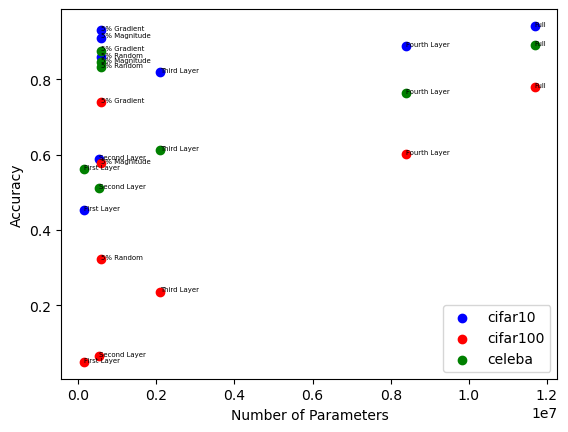

In [41]:
import matplotlib.pyplot as plt
fontsize = 5
plt.scatter(xs, cifar10, label='cifar10', color='blue')
plt.scatter(xs, cifar100, label='cifar100', color='red')
plt.scatter(xs, celeba, label='celeba', color='green')
plt.legend()
for i in range(len(cifar10)):
    plt.text(xs[i], cifar10[i], labels[i], fontsize=fontsize)
    plt.text(xs[i], cifar100[i], labels[i], fontsize=fontsize)
    plt.text(xs[i], celeba[i], labels[i], fontsize=fontsize)
plt.xlabel("Number of Parameters")
plt.ylabel("Accuracy")
plt.show()